In [1]:
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
original_df = pd.read_csv("../0. Data/classification_data.csv")
original_df = original_df.drop(columns=["Recycle ratio (total return sludge flow/total influent flow).1"])
original_df.columns.to_list()

['Sample',
 'Position',
 'Country',
 'City',
 'Plant',
 'Date',
 'Volume of aeration tanks (m3)',
 'Actual Inf rate (m3/d)',
 '‚ÑÉ Temp.Max.SamplingDate',
 '‚ÑÉ Temp.Avg.SamplingDate',
 '‚ÑÉ Temp.Min.SamplingDate',
 '‚ÑÉ Dew.Max.SamplingDate',
 '‚ÑÉ Dew.Avg.SamplingDate',
 '‚ÑÉ Dew.Min.SamplingDate',
 '‚ÑÉ Humidity.Max.SamplingDate',
 '‚ÑÉ Humidity.Min.SamplingDate',
 '‚ÑÉ Wind.Max.SamplingDate',
 '‚ÑÉ Wind.Min.SamplingDate',
 '‚ÑÉ Pressure.Max.SamplingDate',
 '‚ÑÉ Pressure.Min.SamplingDate',
 '‚ÑÉ Precipitation.SamplingDate',
 '‚ÑÉ Temp.Max.WeekMean',
 '‚ÑÉ Temp.Avg.WeekMean',
 '‚ÑÉ Temp.Min.WeekMean',
 '‚ÑÉ Dew.Max.WeekMean',
 '‚ÑÉ Dew.Avg.WeekMean',
 '‚ÑÉ Dew.Min.WeekMean',
 '‚ÑÉ Humidity.Max.WeekMean',
 '‚ÑÉ Humidity.Min.WeekMean',
 '‚ÑÉ Wind.Max.WeekMean',
 '‚ÑÉ Wind.Min.WeekMean',
 '‚ÑÉ Pressure.Max.WeekMean',
 '‚ÑÉ Pressure.Min.WeekMean',
 '‚ÑÉ Precipitation.WeekMean',
 '‚ÑÉ Temp.Max.WeekMax',
 '‚ÑÉ Temp.Avg.WeekMax',
 '‚ÑÉ Temp.Min.WeekMax',
 '‚ÑÉ Dew.Max.WeekMax',
 '‚ÑÉ Dew.Av

In [3]:
as_list = [
    'NewcastleAS', 'VarbergAS', 'SFAS',
    'Beijing3AS', 'Beijing2AS', 'GuangzhouAS',
    'KnoxvilleASP1', 'KnoxvilleASP2', 'KnoxvilleASP3',
    'DurbanASP1', 'DurbanASP2', 'DurbanASP3', 'DurbanASP4',
    'LisbonAS', 'ChicagoAS',
    'NormanASP1', 'NormanASP2', 'NormanASP3'
]

filtered_df = original_df[original_df["Position"].isin(as_list)]
len(as_list)
print(original_df["Position"].unique(), filtered_df["Position"].unique())

['NewcastleAS' 'VarbergAS' 'VarbergINF' 'SFAS' 'SFINF' 'Bejing3INF'
 'Beijing3AS' 'Beijing2AS' 'Beijing2INF' 'GuangzhouINF' 'GuangzhouAS'
 'KnoxvilleINF' 'KnoxvilleASP1' 'KnoxvilleASP2' 'KnoxvilleASP3'
 'DurbanASP1' 'DurbanASP2' 'DurbanASP3' 'DurbanASP4' 'LisbonINF'
 'LisbonAS' 'ChicagoAS' 'NormanINF' 'NormanASP1' 'NormanASP2' 'NormanASP3'
 'NormanEFF'] ['NewcastleAS' 'VarbergAS' 'SFAS' 'Beijing3AS' 'Beijing2AS' 'GuangzhouAS'
 'KnoxvilleASP1' 'KnoxvilleASP2' 'KnoxvilleASP3' 'DurbanASP1' 'DurbanASP2'
 'DurbanASP3' 'DurbanASP4' 'LisbonAS' 'ChicagoAS' 'NormanASP1'
 'NormanASP2' 'NormanASP3']


In [4]:
X_svd_df = pd.read_csv("../0. Data/ESV_SVD_25D.csv", index_col=0)
X_svd_df

SVD_1       SVD_2       SVD_3        SVD_4        SVD_5  \
UK01A  119.512586   30.206870  257.892781   244.542209  1476.170952   
UK02A  184.855875   44.575649  394.888152   340.562363  2222.852732   
UK03A  176.093600   47.116199  391.320514   351.139450  2224.944927   
UK04A  188.055920   45.143048  405.899105   335.812563  2275.728090   
UK05A  183.131358   45.603622  414.252648   326.158036  2297.905647   
...           ...         ...         ...          ...          ...   
GZ101  494.238896  -38.824252   31.679222   121.701359   359.688041   
GZ102  305.125160   42.983298   41.087944   183.634098   399.361700   
GZ103  189.396822   91.082964   48.823397   181.868279   492.019812   
GZ104  156.687353  127.642448   46.379917   193.862037   501.665470   
N01A   462.156252  -19.362337   94.631448  1235.493881   230.655408   

             SVD_6        SVD_7        SVD_8        SVD_9      SVD_10  ...  \
UK01A  -886.607324   877.460751  -748.717582  -459.228337 -222.319253  ...   
UK02A -1271.239892  1316.628486 -1090.680760  -736.107534 -323.143894  ...   
UK03A -1291.757728  1319.204476 -1115.554144  -725.117653 -331.408948  ...   
UK04A -1367.835375  1378.402861 -1152.497381  -787.089174 -359.224185  ...   
UK05A -1415.437251  1424.057599 -1168.939447  -812.225139 -382.059660  ...   
...            ...          ...          ...          ...         ...  ...   
GZ101    -1.272138    50.041731   354.381228   781.470751  212.451309  ...   
GZ102    15.441426    74.218017   416.102790   817.795276  118.619032  ...   
GZ103    38.842927    82.219243   506.441452  1299.410536  137.176615  ...   
GZ104    40.127084    70.643125   529.404743  1460.791904  158.691635  ...   
N01A   -139.768504  -292.801090    11.159132    -1.354482  -26.593251  ...   

           SVD_16      SVD_17      SVD_18      SVD_19      SVD_20      SVD_21  \
UK01A  359.310911  -89.069847   35.938781  -80.955725   74.555696  204.643887   
UK02A  590.358520  -68.025554 -130.805420 -132.906720  124.226026  291.279505   
UK03A  573.401686  -61.099369 -127.653732 -125.362428  118.647594  264.290790   
UK04A  598.514885 -104.100813 -251.199593 -164.765123  188.262919  316.618341   
UK05A  649.802823 -171.539529 -265.680254 -160.743738  161.550729  365.633693   
...           ...         ...         ...         ...         ...         ...   
GZ101 -112.166328   58.385814  102.919704   72.808057  -94.706035  -13.287829   
GZ102  -79.298511   51.476070   23.173439   75.400952  -81.106475  -41.925868   
GZ103 -100.969706   23.984718  -30.219658  158.638139 -247.486326   36.096102   
GZ104 -103.062245  -62.725783   -0.736163  183.274059 -249.849197    1.157861   
N01A  -147.073927   56.486002  -17.592490    2.664262   14.296342  -52.015332   

           SVD_22      SVD_23      SVD_24      SVD_25  
UK01A  -44.432424  -75.566567  -28.152542 -139.776911  
UK02A  -43.424642  -21.048832 -121.881068 -222.789861  
UK03A  -21.878628  -38.734378  -73.757111 -183.435814  
UK04A  -25.531131   10.909645 -205.971329 -358.286225  
UK05A  -83.970978   -1.510278 -207.412524 -486.803164  
...           ...         ...         ...         ...  
GZ101  140.859177  199.582808   72.440998 -135.446180  
GZ102   50.742185  150.559234   90.515057  -98.718260  
GZ103  117.122560   71.440781  237.915310 -110.151610  
GZ104  190.774279   53.071887  324.480931 -144.010866  
N01A     5.696567   93.906927  -54.556106  -58.437502  

[1243 rows x 25 columns]

In [5]:

filtered_df_indexed = filtered_df.set_index("Sample")

# X_svd_dfÏôÄ Î≥ëÌï©
merged_df = filtered_df_indexed.join(X_svd_df, how="inner")

# Í≤∞Í≥º ÌôïÏù∏
print(merged_df.shape)
merged_df

(813, 115)


Position        Country       City   Plant        Date  \
UK01A  NewcastleAS  United Kindom  Newcastle  UKTM1A  2015-01-28   
UK02A  NewcastleAS  United Kindom  Newcastle  UKTM1A  2015-02-04   
UK03A  NewcastleAS  United Kindom  Newcastle  UKTM1A  2015-02-11   
UK04A  NewcastleAS  United Kindom  Newcastle  UKTM1A  2015-02-18   
UK05A  NewcastleAS  United Kindom  Newcastle  UKTM1A  2015-02-25   
...            ...            ...        ...     ...         ...   
N48C    NormanASP3  United States     Norman   USNO2  2015-12-23   
N49C    NormanASP3  United States     Norman   USNO2  2015-12-30   
N50C    NormanASP3  United States     Norman   USNO2  2016-01-06   
N51C    NormanASP3  United States     Norman   USNO2  2016-01-13   
N52C    NormanASP3  United States     Norman   USNO2  2016-01-20   

       Volume of aeration tanks (m3)  Actual Inf rate (m3/d)  \
UK01A                         3600.0                 17254.0   
UK02A                         3600.0                  7007.0   
UK03A                         3600.0                  7197.0   
UK04A                         3600.0                  6126.0   
UK05A                         3600.0                  6898.0   
...                              ...                     ...   
N48C                          9751.2                 31922.0   
N49C                          9751.2                 45538.0   
N50C                          9751.2                 39274.0   
N51C                          9751.2                 34284.0   
N52C                          9751.2                 37680.0   

       ‚ÑÉ Temp.Max.SamplingDate  ‚ÑÉ Temp.Avg.SamplingDate  \
UK01A                     6.67                     3.33   
UK02A                     5.56                     3.33   
UK03A                     5.56                     4.44   
UK04A                    11.67                    10.00   
UK05A                    10.56                     7.78   
...                        ...                      ...   
N48C                     20.56                     9.44   
N49C                      0.56                    -2.22   
N50C                     11.67                     8.33   
N51C                     14.44                     5.56   
N52C                     10.00                     2.78   

       ‚ÑÉ Temp.Min.SamplingDate  ...      SVD_16      SVD_17      SVD_18  \
UK01A                     0.56  ...  359.310911  -89.069847   35.938781   
UK02A                     0.56  ...  590.358520  -68.025554 -130.805420   
UK03A                     2.78  ...  573.401686  -61.099369 -127.653732   
UK04A                     8.89  ...  598.514885 -104.100813 -251.199593   
UK05A                     5.56  ...  649.802823 -171.539529 -265.680254   
...                        ...  ...         ...         ...         ...   
N48C                     -1.67  ...   79.002384 -127.434802  376.146945   
N49C                     -5.56  ...   16.530354  -34.585756  301.029151   
N50C                      4.44  ...  -78.089860 -222.846491  431.170700   
N51C                     -3.33  ... -178.605008 -386.187801  824.720211   
N52C                     -5.00  ... -102.272661 -373.873753  833.040637   

           SVD_19      SVD_20      SVD_21      SVD_22      SVD_23      SVD_24  \
UK01A  -80.955725   74.555696  204.643887  -44.432424  -75.566567  -28.152542   
UK02A -132.906720  124.226026  291.279505  -43.424642  -21.048832 -121.881068   
UK03A -125.362428  118.647594  264.290790  -21.878628  -38.734378  -73.757111   
UK04A -164.765123  188.262919  316.618341  -25.531131   10.909645 -205.971329   
UK05A -160.743738  161.550729  365.633693  -83.970978   -1.510278 -207.412524   
...           ...         ...         ...         ...         ...         ...   
N48C    19.078335  -74.248669  103.338832 -214.610152 -190.040699  242.680544   
N49C    29.531855   43.658539 -140.688473  100.361306  230.568493 -241.501097   
N50C    38.761832 -266.749614  451.700897 -581.428367 -649.538278  782.778535  

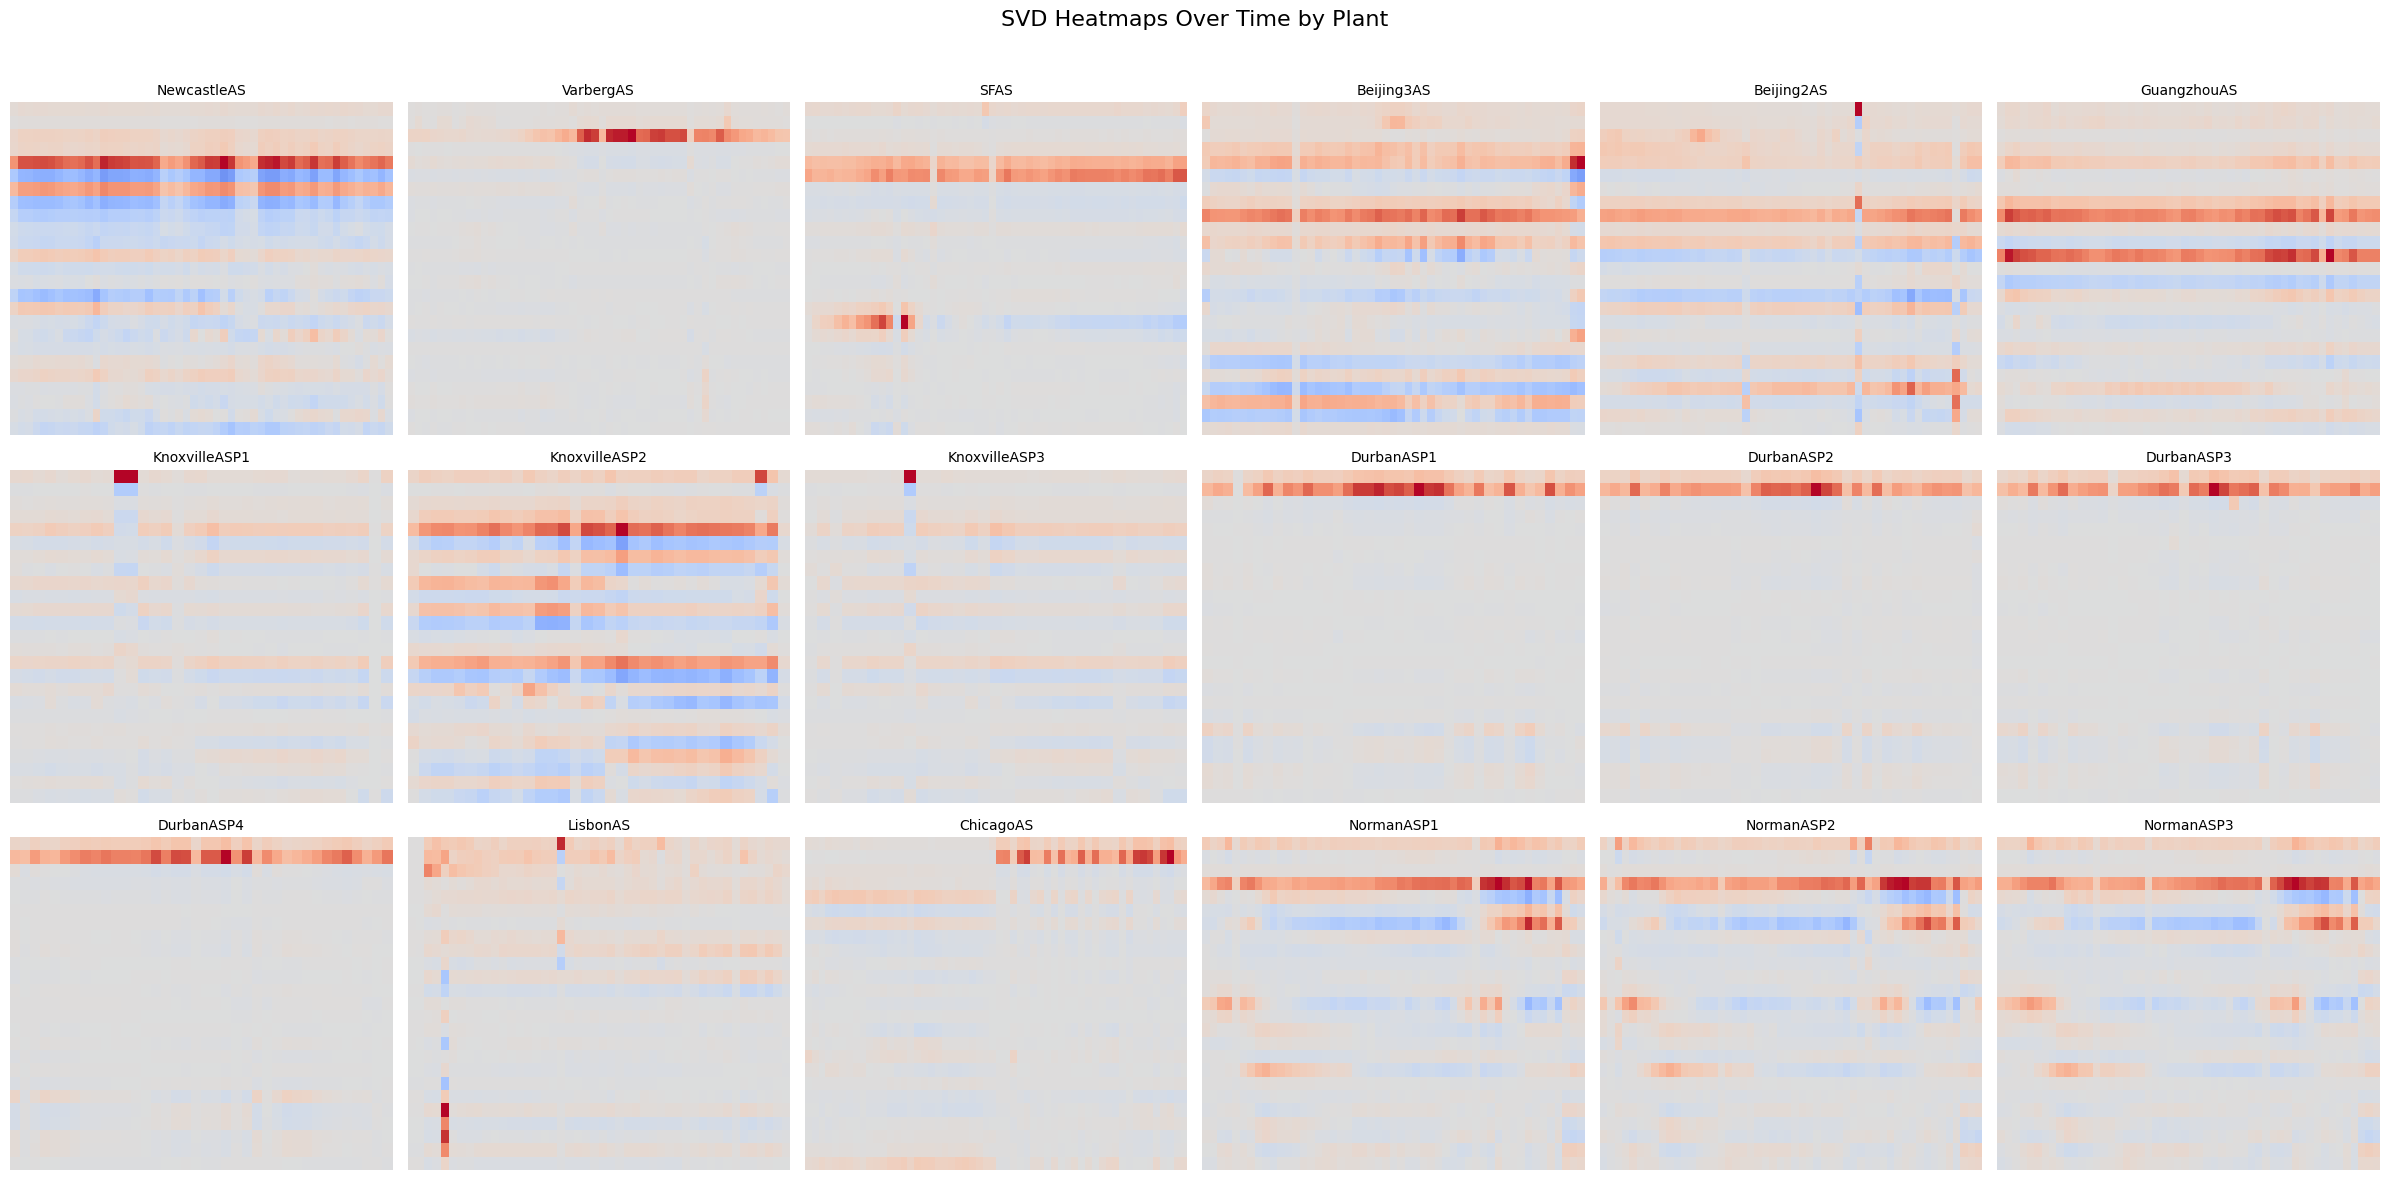

In [7]:

# SVD Ïª¨Îüº
svd_cols = [col for col in merged_df.columns if col.startswith("SVD_")]

# DateÎ•º datetimeÏúºÎ°ú Î≥ÄÌôò
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

# Plant Î¶¨Ïä§Ìä∏ (ÏÉÅÏúÑ 18Í∞úÎßå ÏÇ¨Ïö©)
plant_list = merged_df["Position"].unique()[:18]

# ÏÑúÎ∏åÌîåÎ°Ø ÏÑ§Ï†ï
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24, 12))
axes = axes.flatten()

for i, plant_name in enumerate(plant_list):
    ax = axes[i]

    group_df = merged_df[merged_df["Position"] == plant_name].sort_values("Date")

    if group_df.shape[0] < 3:
        ax.set_visible(False)
        continue

    group_df = group_df.set_index("Date")
    svd_data = group_df[svd_cols].T  # SVDs on y-axis

    sns.heatmap(svd_data, cmap="coolwarm", center=0, ax=ax,
                cbar=False, xticklabels=False, yticklabels=False)

    ax.set_title(plant_name, fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")

# Ï†ÑÏ≤¥ Î†àÏù¥ÏïÑÏõÉ Ï°∞Ï†ï
plt.suptitle("SVD Heatmaps Over Time by Plant", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


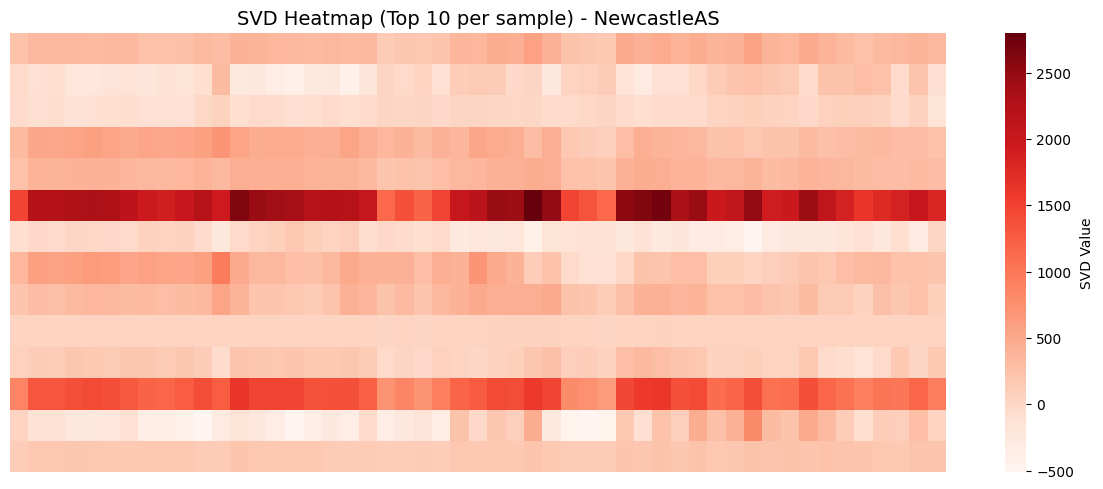

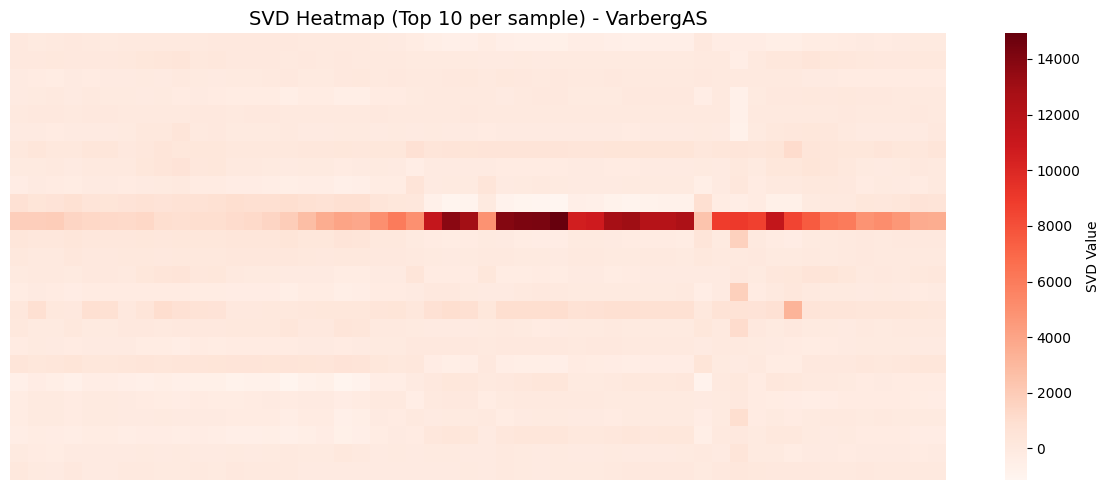

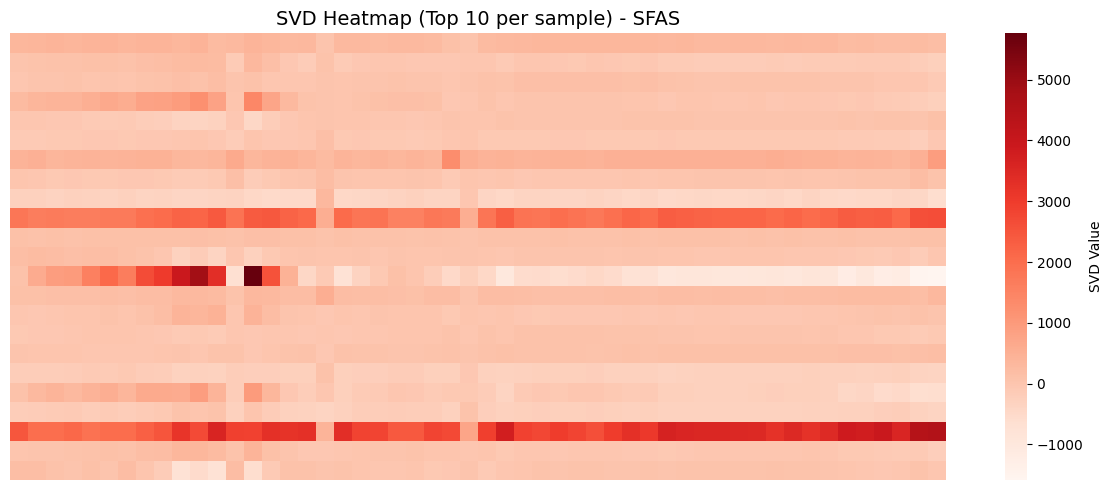

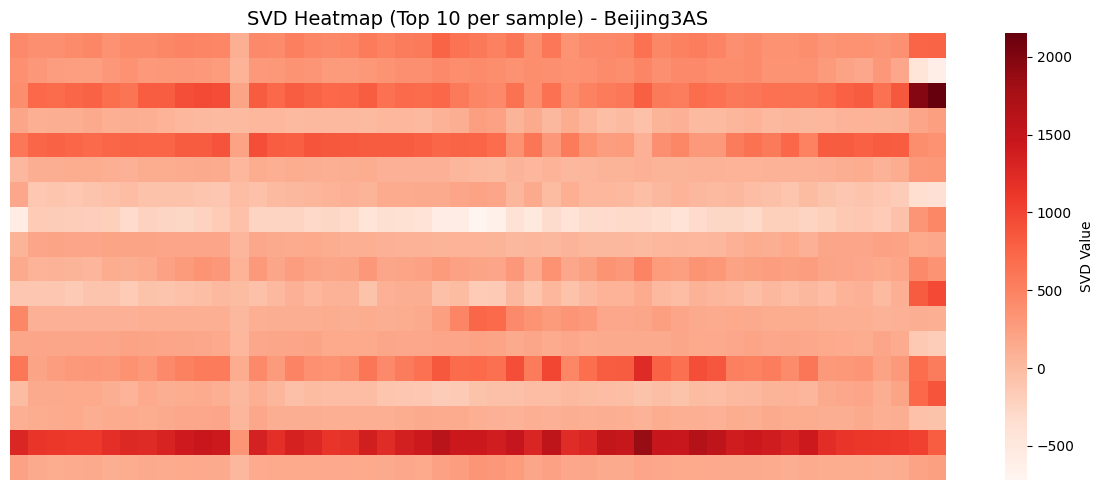

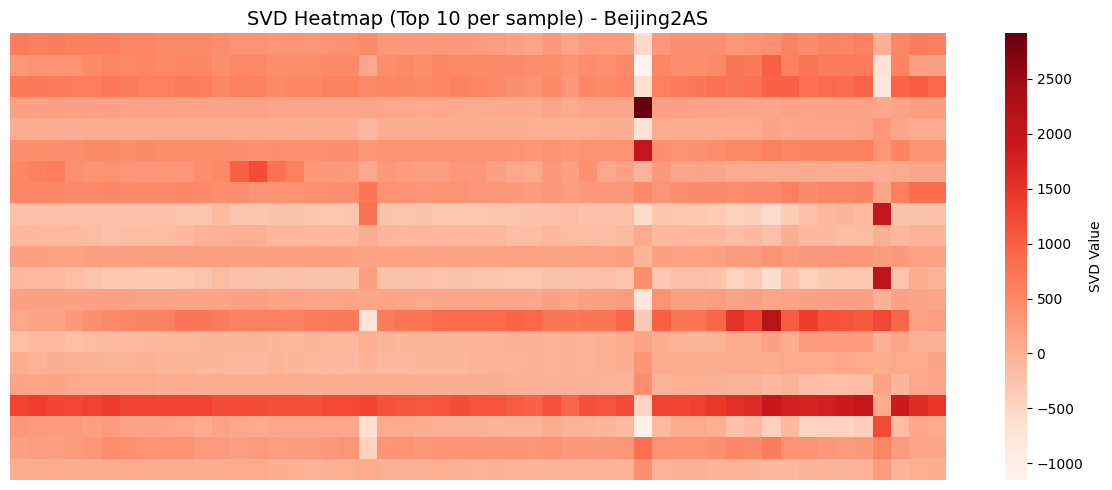

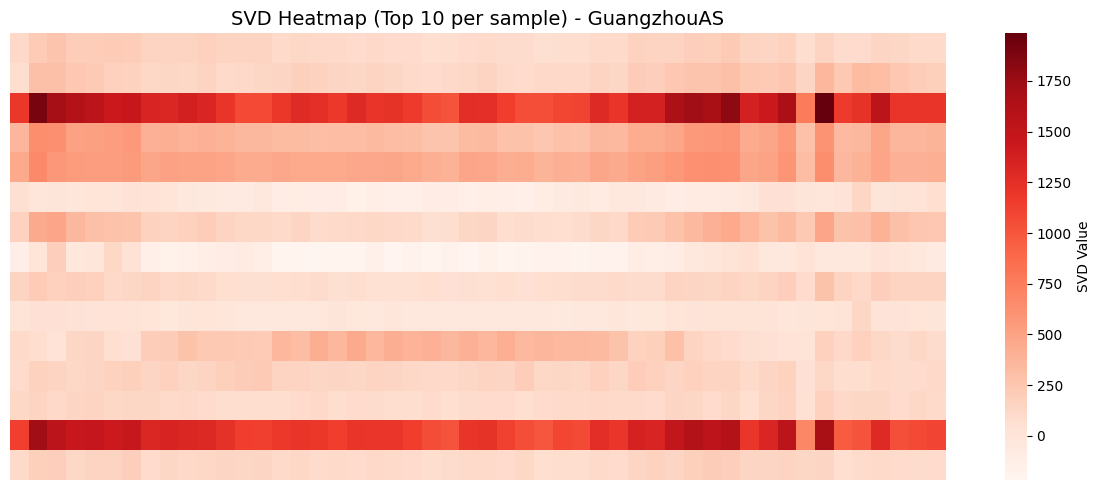

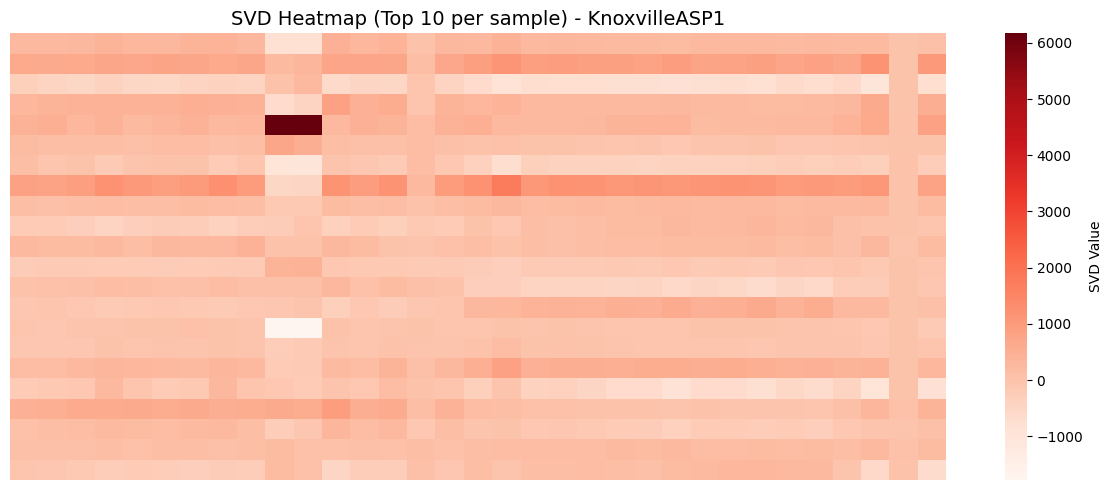

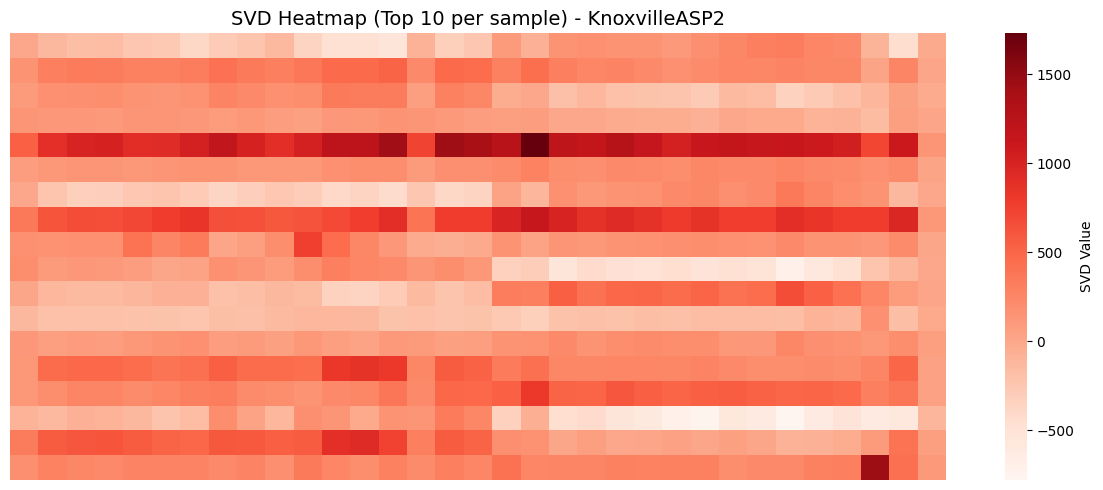

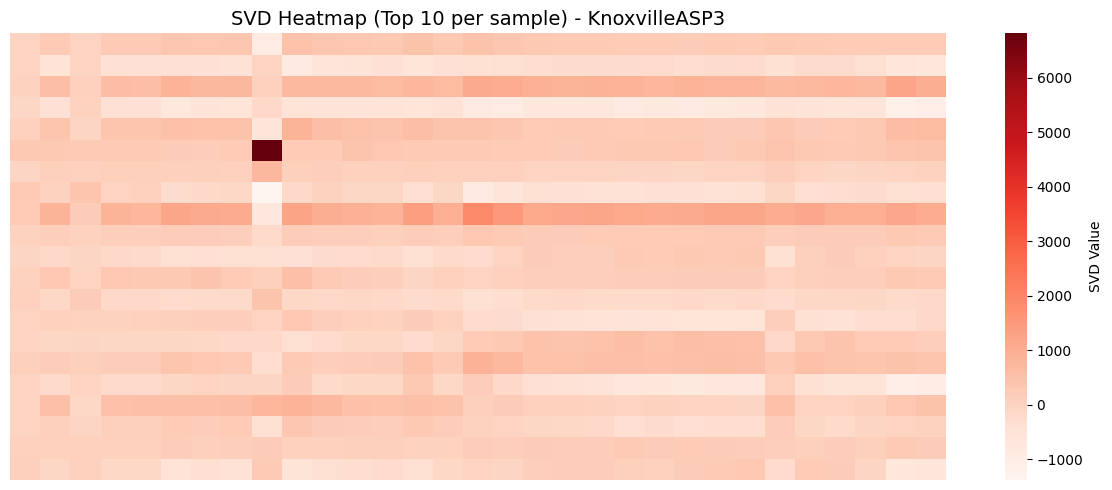

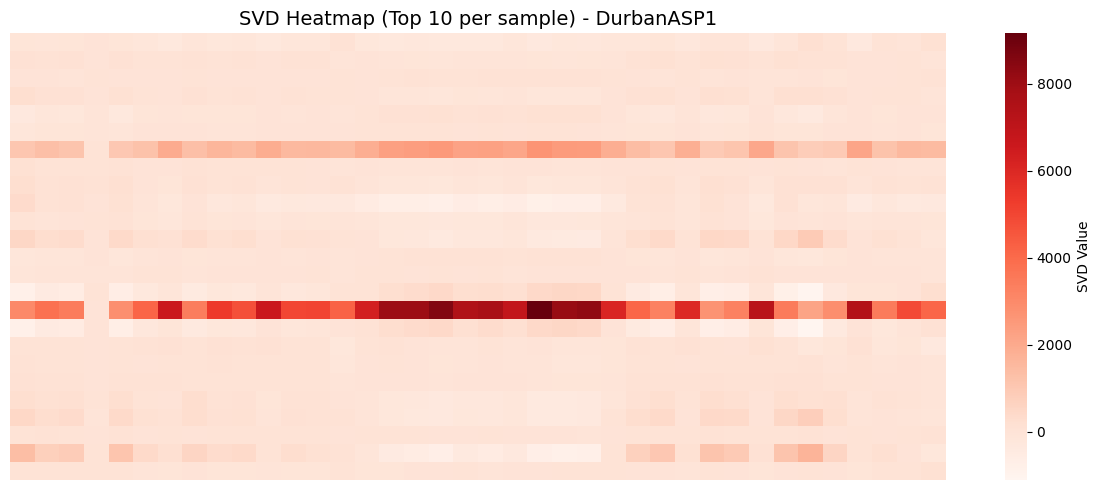

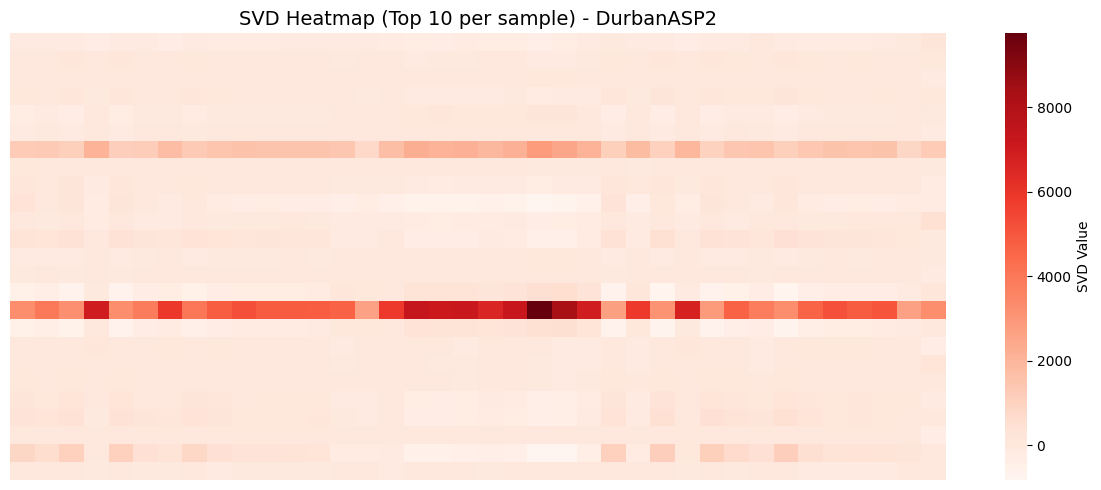

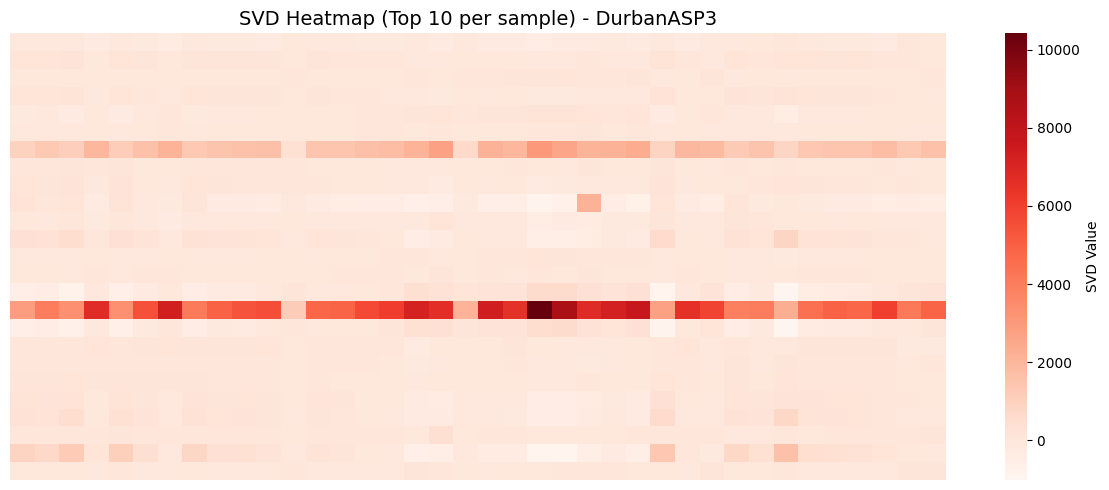

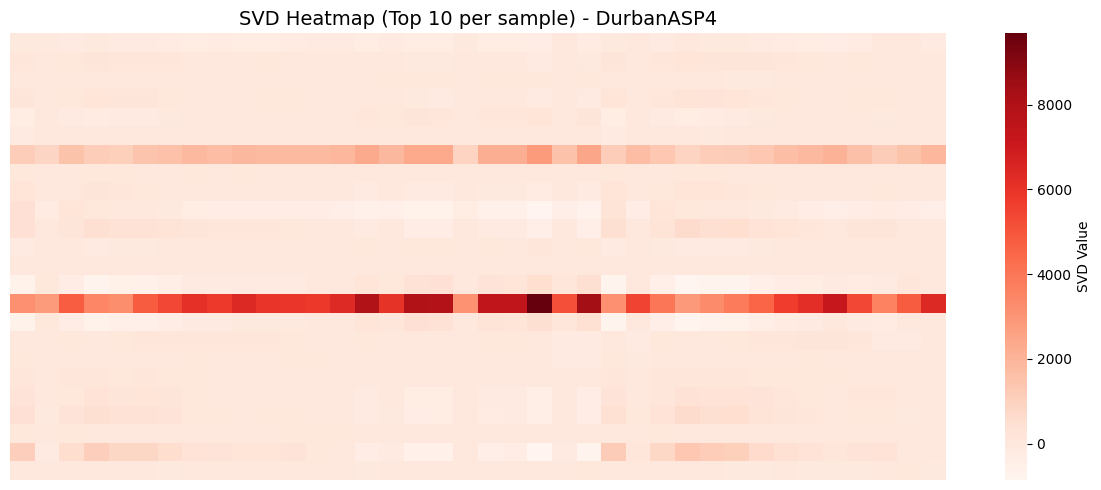

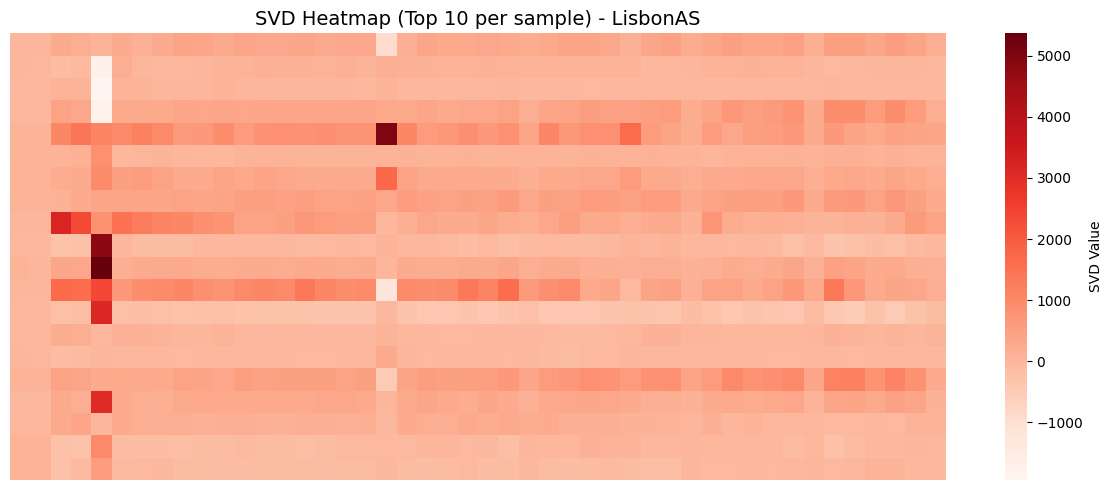

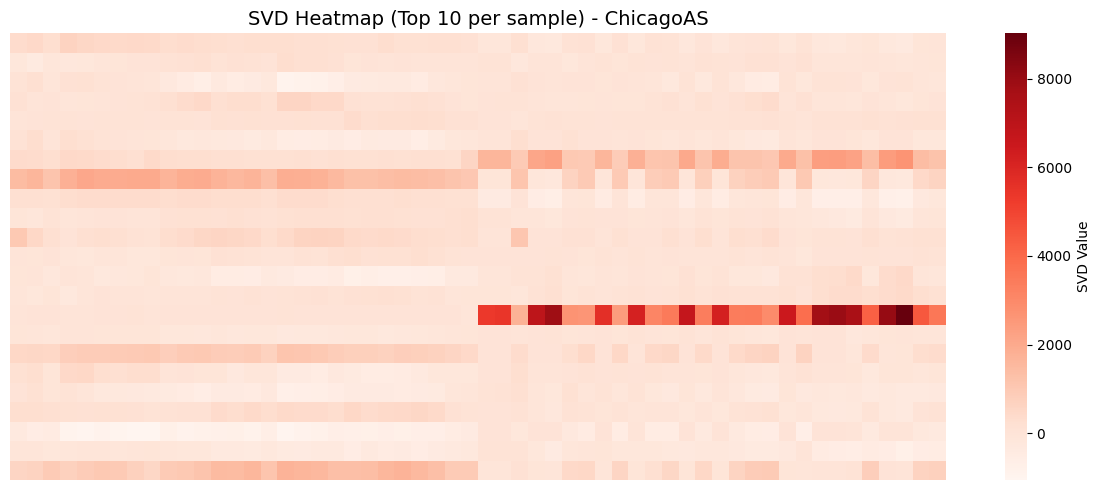

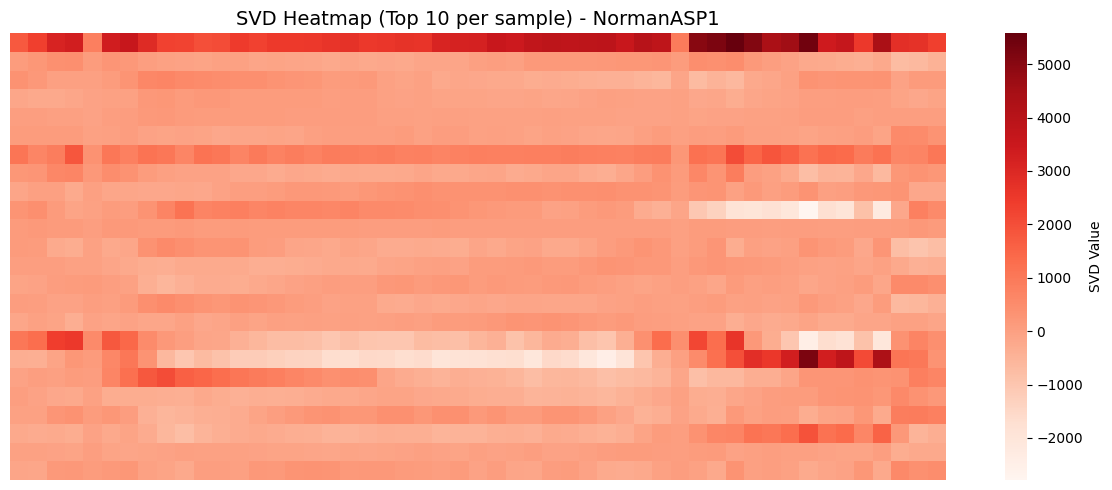

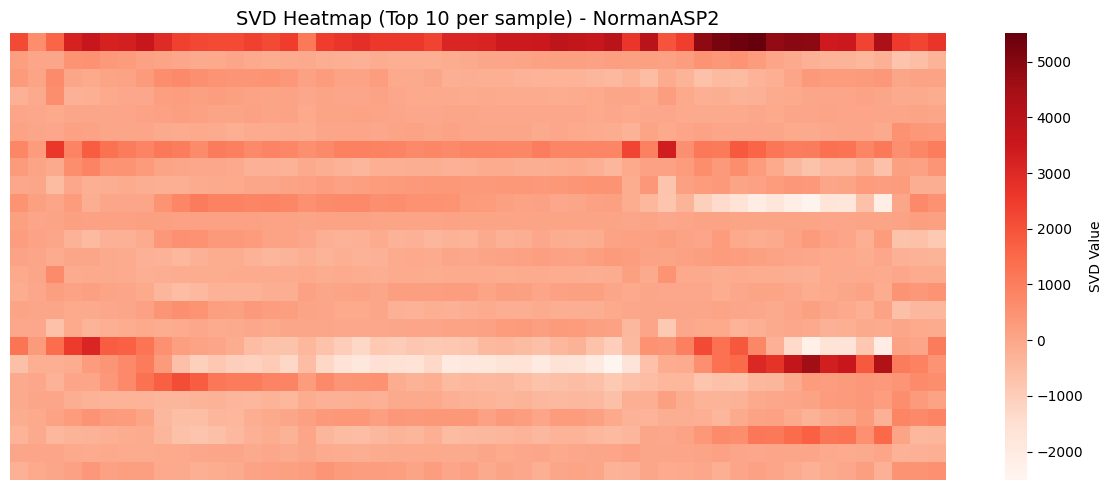

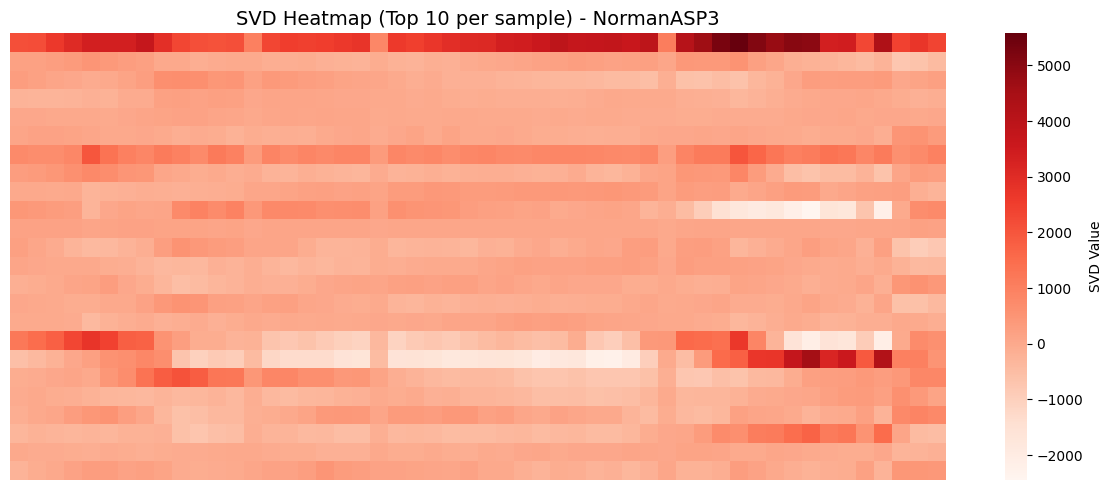

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# SVD Ïª¨Îüº Î¶¨Ïä§Ìä∏
svd_cols = [col for col in merged_df.columns if col.startswith("SVD_")]

# ÎÇ†Ïßú Ï≤òÎ¶¨
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

# ÌîåÎûúÌä∏ Î¶¨Ïä§Ìä∏
plant_list = merged_df["Position"].unique()[:18]

for plant_name in plant_list:
    group_df = merged_df[merged_df["Position"] == plant_name].sort_values("Date")

    if group_df.shape[0] < 3:
        continue

    group_df = group_df.set_index("Date")
    svd_only = group_df[svd_cols]

    # Í∞Å row(ÎÇ†Ïßú)Ïóê ÎåÄÌï¥ ÏÉÅÏúÑ 10Í∞ú SVD Ïª¨ÎüºÎßå ÎÇ®Í∏∞Í∏∞
    top10_svd_cols = svd_only.apply(lambda row: row.nlargest(10).index, axis=1)
    top_svd_set = set(top10_svd_cols.explode())  # Ïú†ÎãàÌÅ¨Ìïú Ïª¨ÎüºÎßå Ï∂îÏ∂ú

    # ÌïÑÌÑ∞ÎßÅÎêú SVD Îç∞Ïù¥ÌÑ∞ (ÏÉÅÏúÑ 10Í∞ú Ïª¨ÎüºÎßå Ïú†ÏßÄ)
    filtered_svd = svd_only[list(top_svd_set)].T

    # ÌûàÌä∏Îßµ Í∑∏Î¶¨Í∏∞
    plt.figure(figsize=(12, 5))
    sns.heatmap(
        filtered_svd,
        cmap="Reds",
        cbar_kws={'label': 'SVD Value'},
        xticklabels=False,
        yticklabels=False
    )

    plt.title(f"SVD Heatmap (Top 10 per sample) - {plant_name}", fontsize=14)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()


In [11]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# SVD Ïª¨ÎüºÎßå
svd_cols = [col for col in merged_df.columns if col.startswith("SVD_")]

# Ï†ÑÏ≤¥ Í≤∞Í≥º Ï†ÄÏû•Ïö©
baseline_mse = {}
baseline_r2 = {}

# Í∞Å ÌîåÎûúÌä∏ Î≥ÑÎ°ú
for plant_name in merged_df["Position"].unique():
    group_df = merged_df[merged_df["Position"] == plant_name].sort_values("Date")

    if group_df.shape[0] < 3:
        continue

    y_true = group_df[svd_cols].iloc[1:].values     # Ïã§Ï†úÍ∞í (t)
    y_pred = group_df[svd_cols].iloc[:-1].values    # ÏßÅÏ†ÑÍ∞íÏúºÎ°ú ÏòàÏ∏° (t-1)

    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    baseline_mse[plant_name] = mse
    baseline_r2[plant_name] = r2

# ÏòàÏãú Ï∂úÎ†•
for plant in list(baseline_mse.keys()):
    print(f"{plant} ‚Üí MSE: {baseline_mse[plant]:.4f}, R¬≤: {baseline_r2[plant]:.4f}")


NewcastleAS ‚Üí MSE: 25705.1492, R¬≤: 0.2546
VarbergAS ‚Üí MSE: 355932.0185, R¬≤: 0.0548
SFAS ‚Üí MSE: 110717.1427, R¬≤: 0.0049
Beijing3AS ‚Üí MSE: 19236.4634, R¬≤: 0.3128
Beijing2AS ‚Üí MSE: 91547.1204, R¬≤: -0.4366
GuangzhouAS ‚Üí MSE: 8862.2345, R¬≤: 0.2115
KnoxvilleASP1 ‚Üí MSE: 151830.9410, R¬≤: -0.0910
KnoxvilleASP2 ‚Üí MSE: 25408.2844, R¬≤: 0.1716
KnoxvilleASP3 ‚Üí MSE: 188144.0921, R¬≤: -0.3655
DurbanASP1 ‚Üí MSE: 217784.0431, R¬≤: -0.0351
DurbanASP2 ‚Üí MSE: 199896.6102, R¬≤: -0.2175
DurbanASP3 ‚Üí MSE: 304356.1957, R¬≤: -0.4514
DurbanASP4 ‚Üí MSE: 203237.8499, R¬≤: -0.1313
LisbonAS ‚Üí MSE: 242118.1118, R¬≤: -0.6285
ChicagoAS ‚Üí MSE: 245873.1577, R¬≤: 0.3902
NormanASP1 ‚Üí MSE: 137378.9501, R¬≤: 0.4261
NormanASP2 ‚Üí MSE: 136319.8758, R¬≤: 0.2970
NormanASP3 ‚Üí MSE: 112459.5829, R¬≤: 0.5259


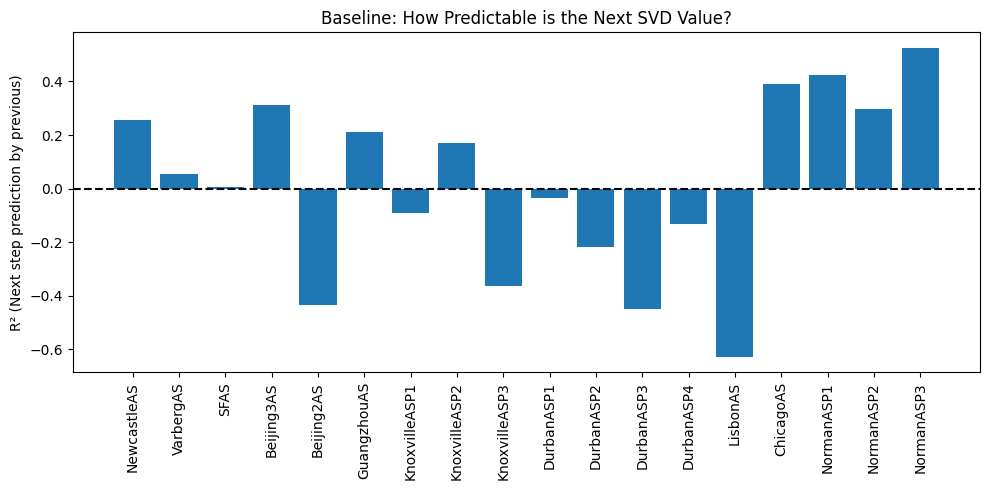

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(baseline_r2.keys(), baseline_r2.values())
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=90)
plt.ylabel("R¬≤ (Next step prediction by previous)")
plt.title("Baseline: How Predictable is the Next SVD Value?")
plt.tight_layout()
plt.show()


In [37]:
from statsmodels.tsa.stattools import adfuller

# Ïòà: ÌäπÏ†ï ÌîåÎûúÌä∏Ïùò SVD_1 ÏãúÍ≥ÑÏó¥
plant = "DurbanASP2"
svd_series = merged_df[merged_df['Position'] == plant].sort_values("Date")["SVD_6"].dropna()

# ADF Test ÏàòÌñâ
result = adfuller(svd_series)

# Ï∂úÎ†•
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value}")


ADF Statistic: -0.6059367068453284
p-value: 0.8696349237248795
Critical Value (1%): -3.6790595944893187
Critical Value (5%): -2.9678817237279103
Critical Value (10%): -2.6231583472057074


In [38]:
# 1Ï∞® Ï∞®Î∂Ñ
diff_series = svd_series.diff().dropna()

# ADF Test on Ï∞®Î∂Ñ Îç∞Ïù¥ÌÑ∞
from statsmodels.tsa.stattools import adfuller
result = adfuller(diff_series)

print(f"ADF Statistic (1Ï∞® Ï∞®Î∂Ñ): {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic (1Ï∞® Ï∞®Î∂Ñ): -0.0494353982921964
p-value: 0.9542478162206319


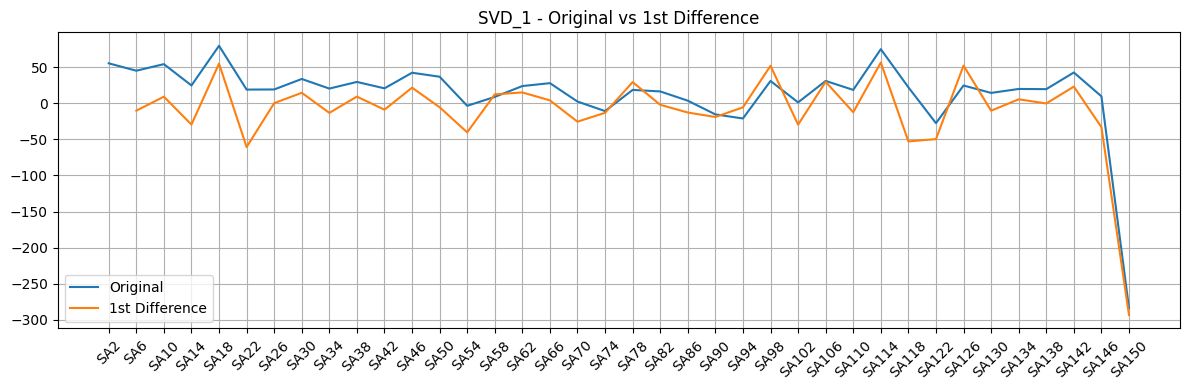

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(svd_series, label='Original')
plt.plot(diff_series, label='1st Difference')

plt.legend()
plt.title("SVD_1 - Original vs 1st Difference")
plt.grid(True)

# ‚úÖ xÏ∂ï ÎùºÎ≤® ÌöåÏ†Ñ
plt.xticks(rotation=45)  # ÎòêÎäî rotation=90 ÏúºÎ°ú ÏôÑÏ†Ñ ÏàòÏßÅ

plt.tight_layout()
plt.show()


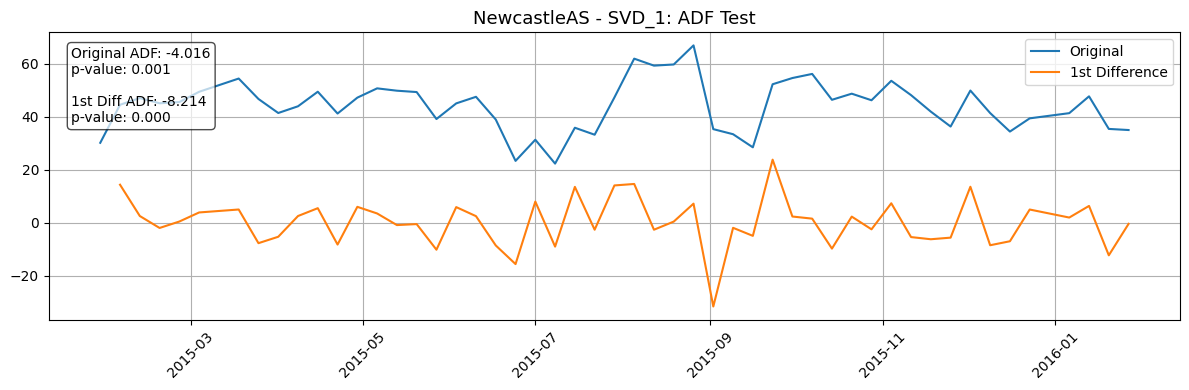

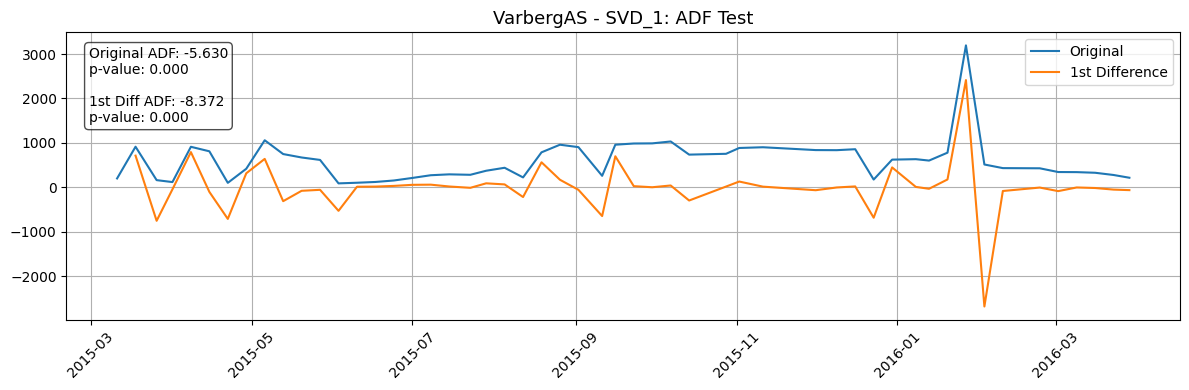

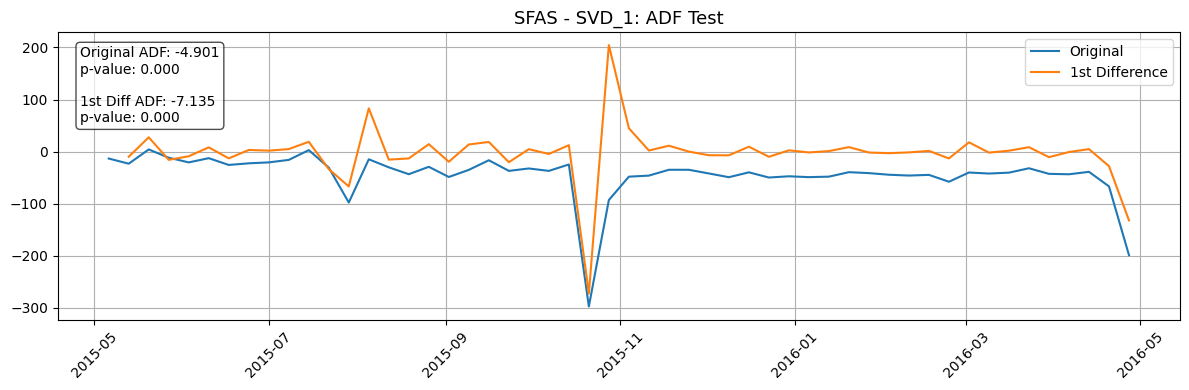

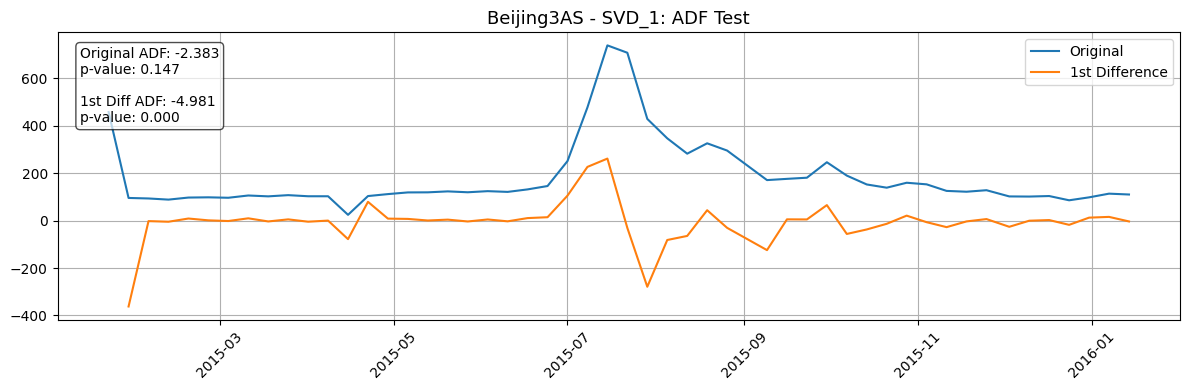

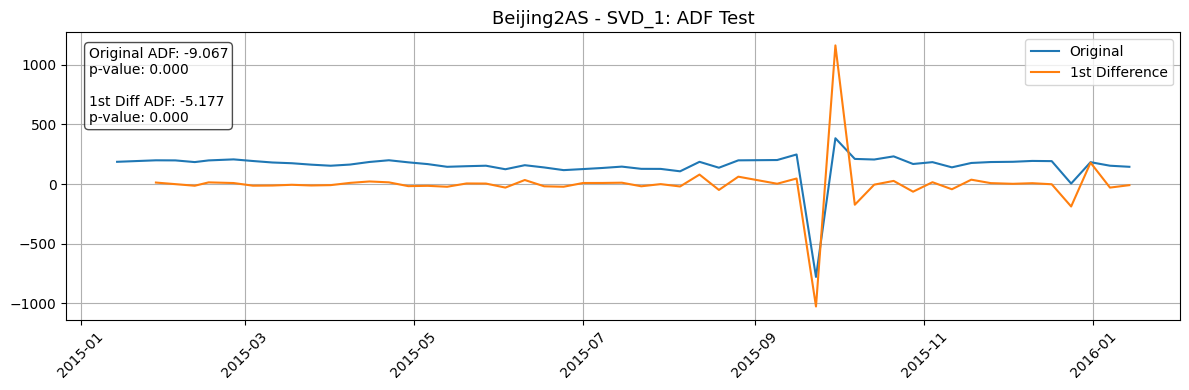

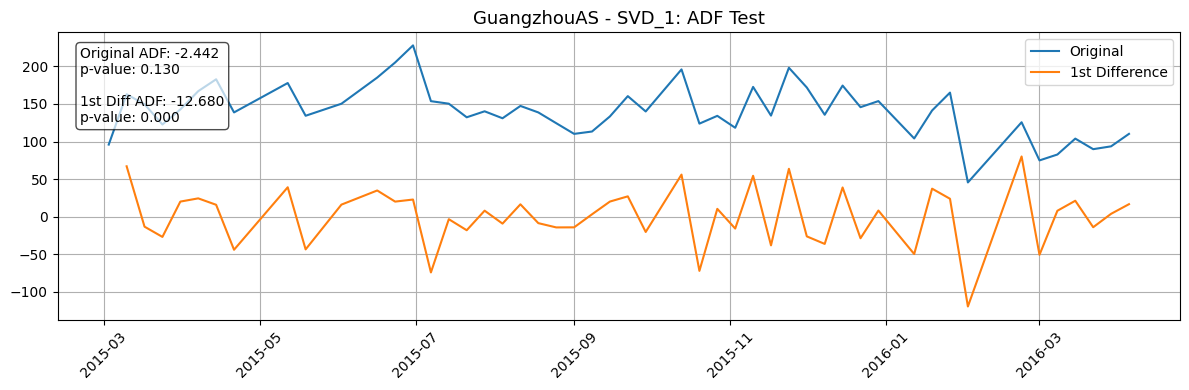

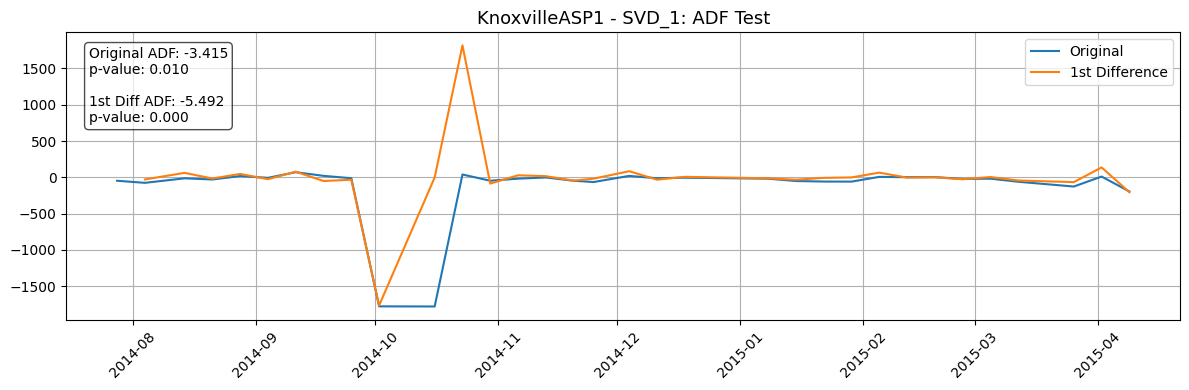

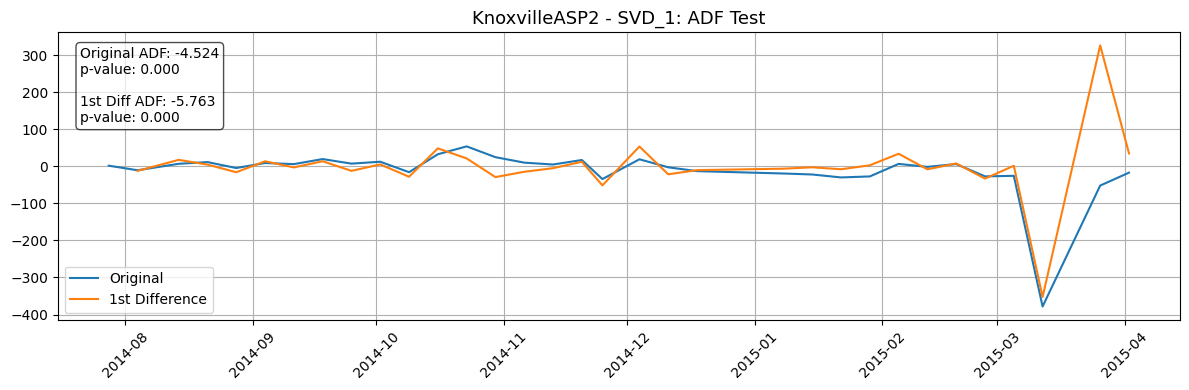

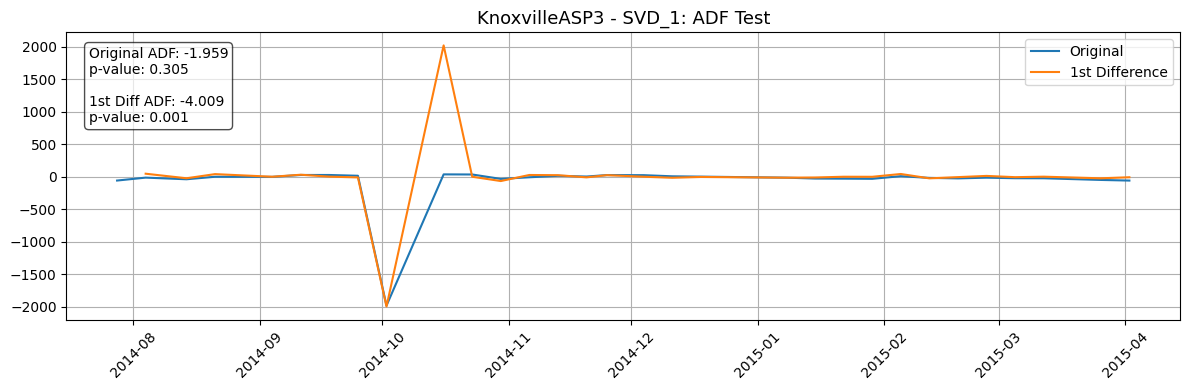

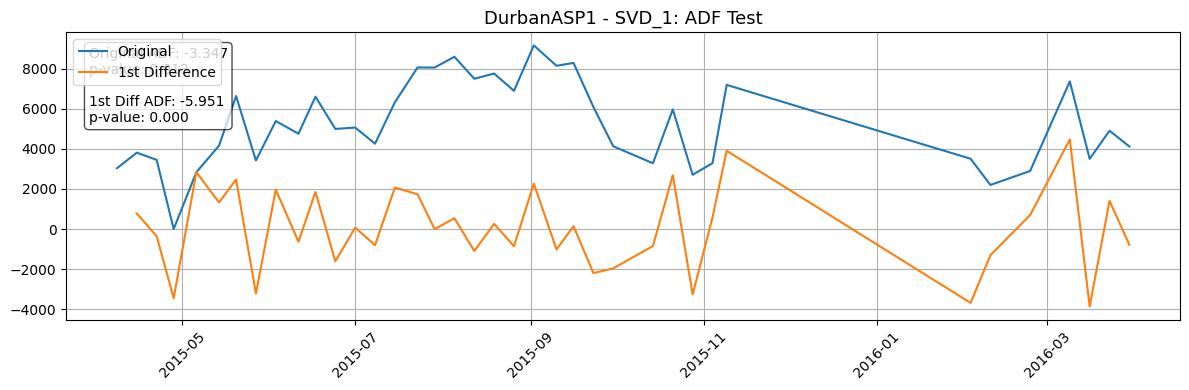

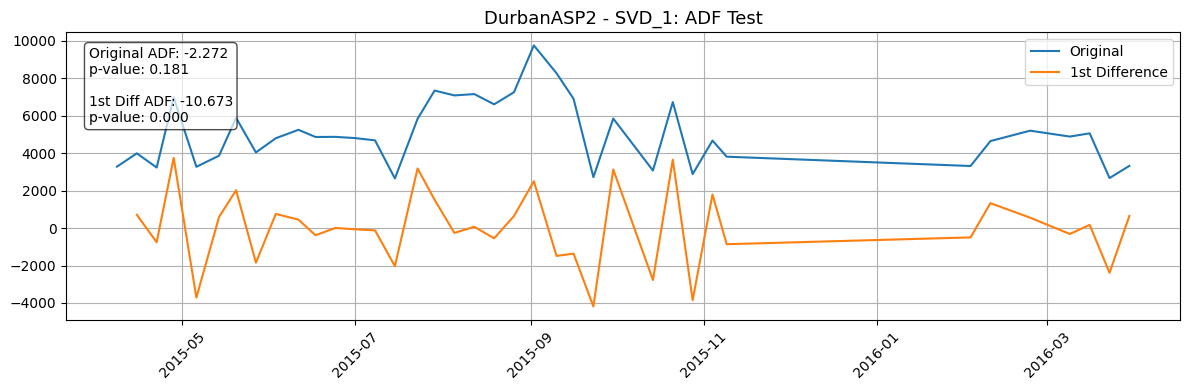

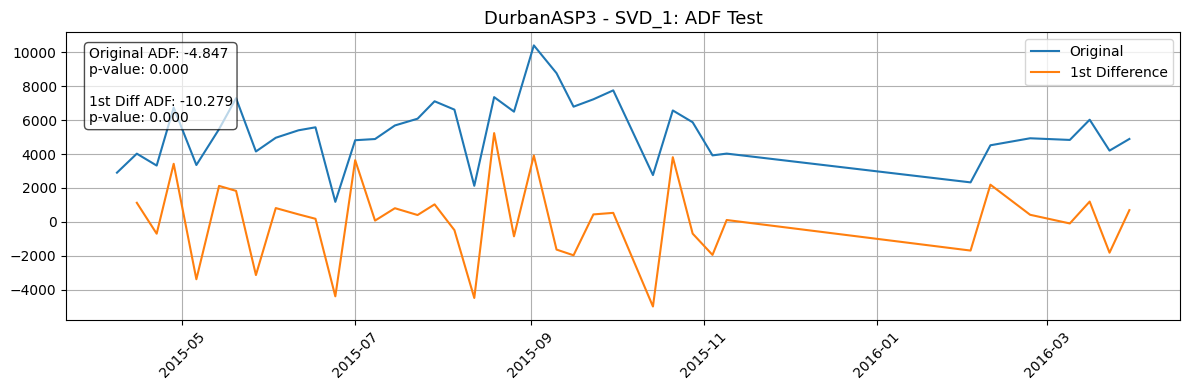

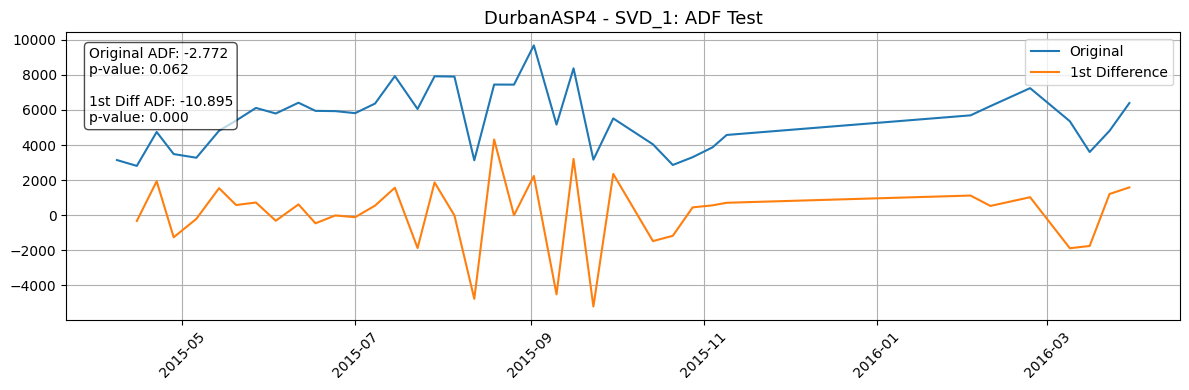

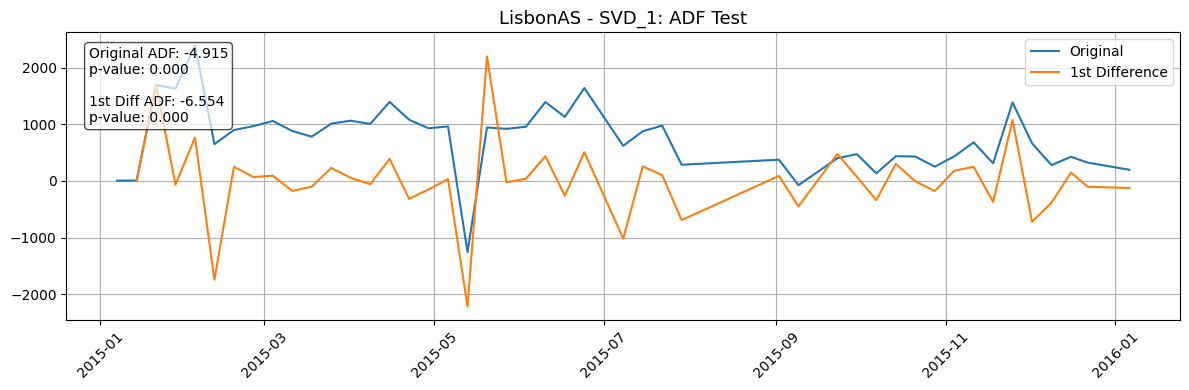

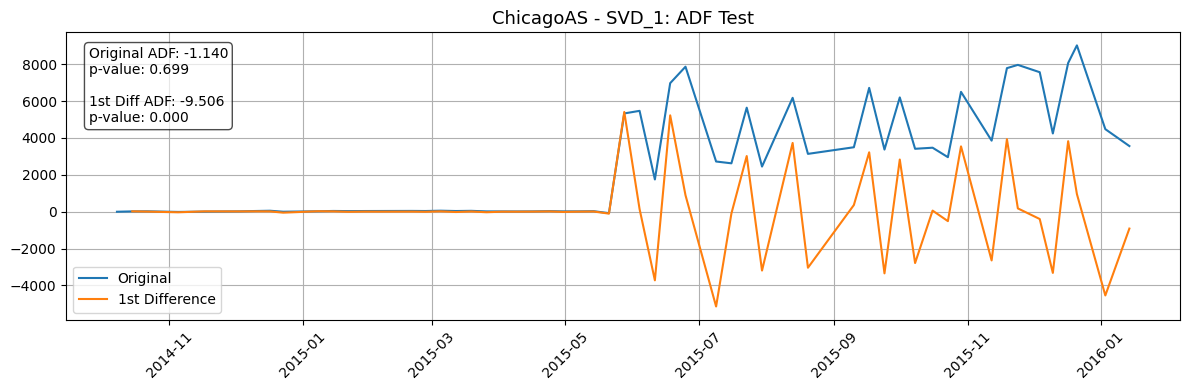

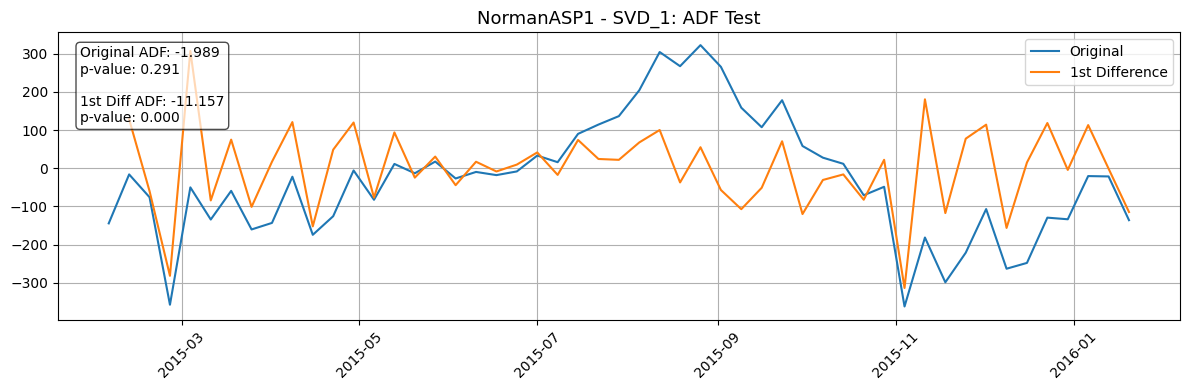

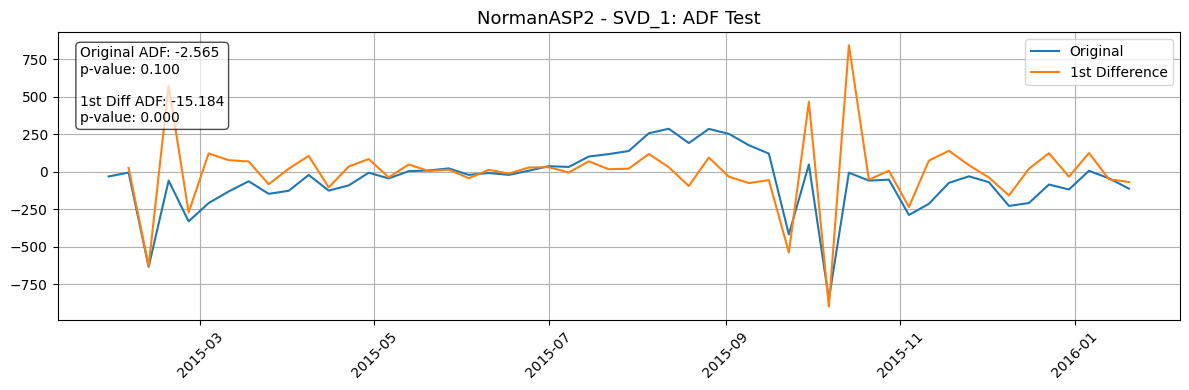

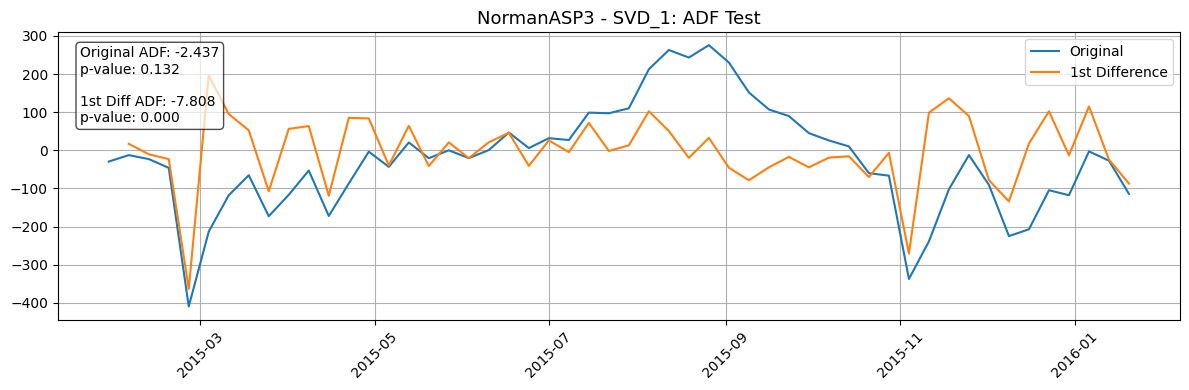

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌï¥ ÌïúÍ∏Ä Íπ®Ïßê Î∞©ÏßÄ (Mac/Windows ÌôòÍ≤ΩÏóê ÎßûÍ≤å ÏÑ§Ï†ï Í∞ÄÎä•)
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac ÏÇ¨Ïö©Ïûê
# plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows ÏÇ¨Ïö©Ïûê

# SVD_1Ïù¥ Ï°¥Ïû¨ÌïòÎäîÏßÄ ÌôïÏù∏
svd_col = "SVD_2"
positions = merged_df["Position"].unique()

for plant in positions:
    try:
        # Ìï¥Îãπ plantÏùò Îç∞Ïù¥ÌÑ∞ Ï†ïÎ†¨
        plant_df = merged_df[merged_df['Position'] == plant].sort_values("Date")
        svd_series = plant_df[svd_col].dropna()

        # Ïù∏Îç±Ïä§Î•º ÎÇ†ÏßúÎ°ú ÏÑ§Ï†ï (ÏãúÍ≥ÑÏó¥Ï†Å ÏùòÎØ∏ Î∞òÏòÅ)
        svd_series.index = plant_df.loc[svd_series.index, "Date"]

        if len(svd_series) < 10:
            continue  # ÎÑàÎ¨¥ ÏßßÏùÄ ÏãúÍ≥ÑÏó¥ÏùÄ skip

        # ADF Test on original
        result_orig = adfuller(svd_series)
        adf_orig_stat = result_orig[0]
        adf_orig_pval = result_orig[1]

        # 1Ï∞® Ï∞®Î∂Ñ
        diff_series = svd_series.diff().dropna()

        # ADF Test on differenced series
        result_diff = adfuller(diff_series)
        adf_diff_stat = result_diff[0]
        adf_diff_pval = result_diff[1]

        # ÏãúÍ∞ÅÌôî
        plt.figure(figsize=(12, 4))
        plt.plot(svd_series, label='Original')
        plt.plot(diff_series, label='1st Difference')

        plt.legend()
        plt.title(f"{plant} - SVD_1: ADF Test", fontsize=13)
        plt.grid(True)
        plt.xticks(rotation=45)

        # ÌÖçÏä§Ìä∏ Î∞ïÏä§Ïóê Í≤∞Í≥º ÏÇΩÏûÖ
        textstr = f"""Original ADF: {adf_orig_stat:.3f}
p-value: {adf_orig_pval:.3f}

1st Diff ADF: {adf_diff_stat:.3f}
p-value: {adf_diff_pval:.3f}"""

        plt.text(0.02, 0.95, textstr, transform=plt.gca().transAxes,
                 fontsize=10, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error in {plant}: {e}")


In [41]:
merged_df

Position        Country       City   Plant       Date  \
UK01A  NewcastleAS  United Kindom  Newcastle  UKTM1A 2015-01-28   
UK02A  NewcastleAS  United Kindom  Newcastle  UKTM1A 2015-02-04   
UK03A  NewcastleAS  United Kindom  Newcastle  UKTM1A 2015-02-11   
UK04A  NewcastleAS  United Kindom  Newcastle  UKTM1A 2015-02-18   
UK05A  NewcastleAS  United Kindom  Newcastle  UKTM1A 2015-02-25   
...            ...            ...        ...     ...        ...   
N48C    NormanASP3  United States     Norman   USNO2 2015-12-23   
N49C    NormanASP3  United States     Norman   USNO2 2015-12-30   
N50C    NormanASP3  United States     Norman   USNO2 2016-01-06   
N51C    NormanASP3  United States     Norman   USNO2 2016-01-13   
N52C    NormanASP3  United States     Norman   USNO2 2016-01-20   

       Volume of aeration tanks (m3)  Actual Inf rate (m3/d)  \
UK01A                         3600.0                 17254.0   
UK02A                         3600.0                  7007.0   
UK03A                         3600.0                  7197.0   
UK04A                         3600.0                  6126.0   
UK05A                         3600.0                  6898.0   
...                              ...                     ...   
N48C                          9751.2                 31922.0   
N49C                          9751.2                 45538.0   
N50C                          9751.2                 39274.0   
N51C                          9751.2                 34284.0   
N52C                          9751.2                 37680.0   

       ‚ÑÉ Temp.Max.SamplingDate  ‚ÑÉ Temp.Avg.SamplingDate  \
UK01A                     6.67                     3.33   
UK02A                     5.56                     3.33   
UK03A                     5.56                     4.44   
UK04A                    11.67                    10.00   
UK05A                    10.56                     7.78   
...                        ...                      ...   
N48C                     20.56                     9.44   
N49C                      0.56                    -2.22   
N50C                     11.67                     8.33   
N51C                     14.44                     5.56   
N52C                     10.00                     2.78   

       ‚ÑÉ Temp.Min.SamplingDate  ...      SVD_16      SVD_17      SVD_18  \
UK01A                     0.56  ...  359.310911  -89.069847   35.938781   
UK02A                     0.56  ...  590.358520  -68.025554 -130.805420   
UK03A                     2.78  ...  573.401686  -61.099369 -127.653732   
UK04A                     8.89  ...  598.514885 -104.100813 -251.199593   
UK05A                     5.56  ...  649.802823 -171.539529 -265.680254   
...                        ...  ...         ...         ...         ...   
N48C                     -1.67  ...   79.002384 -127.434802  376.146945   
N49C                     -5.56  ...   16.530354  -34.585756  301.029151   
N50C                      4.44  ...  -78.089860 -222.846491  431.170700   
N51C                     -3.33  ... -178.605008 -386.187801  824.720211   
N52C                     -5.00  ... -102.272661 -373.873753  833.040637   

           SVD_19      SVD_20      SVD_21      SVD_22      SVD_23      SVD_24  \
UK01A  -80.955725   74.555696  204.643887  -44.432424  -75.566567  -28.152542   
UK02A -132.906720  124.226026  291.279505  -43.424642  -21.048832 -121.881068   
UK03A -125.362428  118.647594  264.290790  -21.878628  -38.734378  -73.757111   
UK04A -164.765123  188.262919  316.618341  -25.531131   10.909645 -205.971329   
UK05A -160.743738  161.550729  365.633693  -83.970978   -1.510278 -207.412524   
...           ...         ...         ...         ...         ...         ...   
N48C    19.078335  -74.248669  103.338832 -214.610152 -190.040699  242.680544   
N49C    29.531855   43.658539 -140.688473  100.361306  230.568493 -241.501097   
N50C    38.761832 -266.749614  451.700897 -581.428367 -649.538278  782.778535   
N51C    23

In [42]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

# Î™®Îì† SVD Ïª¨Îüº Ï∂îÏ∂ú
svd_cols = [col for col in merged_df.columns if col.startswith("SVD_")]

# Í≤∞Í≥º Ï†ÄÏû• Î¶¨Ïä§Ìä∏
results = []

# Í≥µÏ†ï Î¶¨Ïä§Ìä∏
positions = merged_df["Position"].unique()

# Í∞Å Í≥µÏ†ï Î∞è SVD Ïª¨ÎüºÏóê ÎåÄÌï¥ ADF ÏàòÌñâ
for plant in positions:
    plant_df = merged_df[merged_df['Position'] == plant].sort_values("Date")
    plant_df = plant_df.set_index("Date")
    
    for svd_col in svd_cols:
        if svd_col not in plant_df.columns:
            continue

        svd_series = plant_df[svd_col].dropna()
        
        if len(svd_series) < 10:
            continue
        
        try:
            # ADF ÌÖåÏä§Ìä∏ - ÏõêÎ≥∏
            result_orig = adfuller(svd_series)
            adf_stat_orig, pval_orig = result_orig[0], result_orig[1]

            # ADF ÌÖåÏä§Ìä∏ - 1Ï∞® Ï∞®Î∂Ñ
            diff_series = svd_series.diff().dropna()
            result_diff = adfuller(diff_series)
            adf_stat_diff, pval_diff = result_diff[0], result_diff[1]

            # Í≤∞Í≥º Ï†ÄÏû•
            results.append({
                "Position": plant,
                "SVD_Feature": svd_col,
                "ADF_Original": adf_stat_orig,
                "p_Original": pval_orig,
                "ADF_Diff": adf_stat_diff,
                "p_Diff": pval_diff
            })
        except:
            continue

# DataFrame Î≥ÄÌôò
adf_all_df = pd.DataFrame(results)
adf_all_df

Position SVD_Feature  ADF_Original  p_Original  ADF_Diff        p_Diff
0    NewcastleAS       SVD_1     -0.590209    0.873179 -2.757783  6.456184e-02
1    NewcastleAS       SVD_2     -4.016040    0.001329 -8.213559  6.717373e-13
2    NewcastleAS       SVD_3     -4.325824    0.000401 -7.317004  1.221845e-10
3    NewcastleAS       SVD_4     -3.918710    0.001901 -4.492688  2.027092e-04
4    NewcastleAS       SVD_5     -4.334199    0.000387 -7.568227  2.887376e-11
..           ...         ...           ...         ...       ...           ...
445   NormanASP3      SVD_21     -2.247541    0.189445 -7.174975  2.742229e-10
446   NormanASP3      SVD_22     -2.241015    0.191698 -5.705438  7.507208e-07
447   NormanASP3      SVD_23     -2.303293    0.170908 -7.330343  1.132195e-10
448   NormanASP3      SVD_24     -2.321719    0.165059 -7.854361  5.493076e-12
449   NormanASP3      SVD_25     -3.214022    0.019187 -9.172008  2.374430e-15

[450 rows x 6 columns]

In [40]:
adf_all_df

Position SVD_Feature  ADF_Original  p_Original  ADF_Diff  \
0    NewcastleAS       SVD_1     -0.590209    0.873179 -2.757783   
1    NewcastleAS       SVD_2     -4.016040    0.001329 -8.213559   
2    NewcastleAS       SVD_3     -4.325824    0.000401 -7.317004   
3    NewcastleAS       SVD_4     -3.918710    0.001901 -4.492688   
4    NewcastleAS       SVD_5     -4.334199    0.000387 -7.568227   
..           ...         ...           ...         ...       ...   
445   NormanASP3      SVD_21     -2.247541    0.189445 -7.174975   
446   NormanASP3      SVD_22     -2.241015    0.191698 -5.705438   
447   NormanASP3      SVD_23     -2.303293    0.170908 -7.330343   
448   NormanASP3      SVD_24     -2.321719    0.165059 -7.854361   
449   NormanASP3      SVD_25     -3.214022    0.019187 -9.172008   

           p_Diff  ADF_LogDiff     p_LogDiff  
0    6.456184e-02    -2.931509  4.180467e-02  
1    6.717373e-13    -8.840226  1.676253e-14  
2    1.221845e-10    -4.588408  1.356757e-04  
3    2.027092e-04    -4.689027  8.823891e-05  
4    2.887376e-11    -7.666670  1.634262e-11  
..            ...          ...           ...  
445  2.742229e-10    -6.179627  6.502690e-08  
446  7.507208e-07    -1.552502  5.073980e-01  
447  1.132195e-10    -3.848199  2.450938e-03  
448  5.493076e-12   -11.104616  3.790096e-20  
449  2.374430e-15    -6.609449  6.431918e-09  

[450 rows x 8 columns]

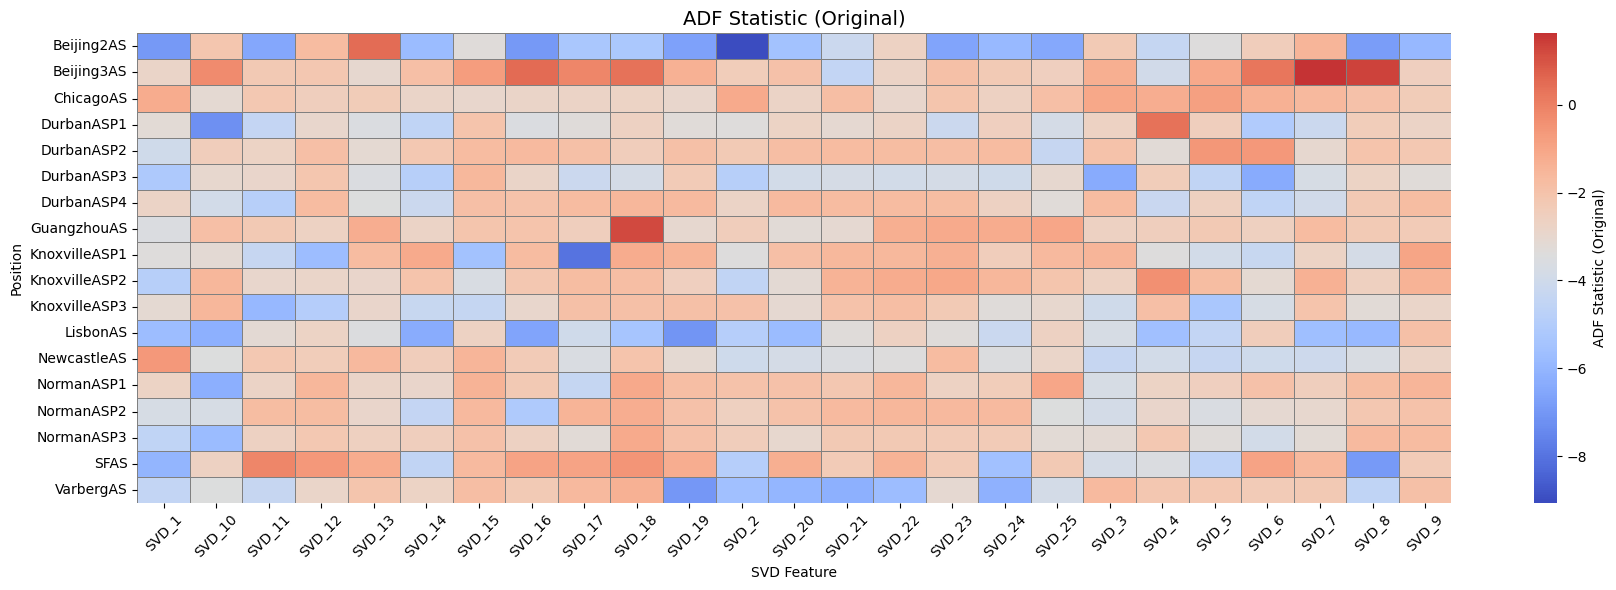

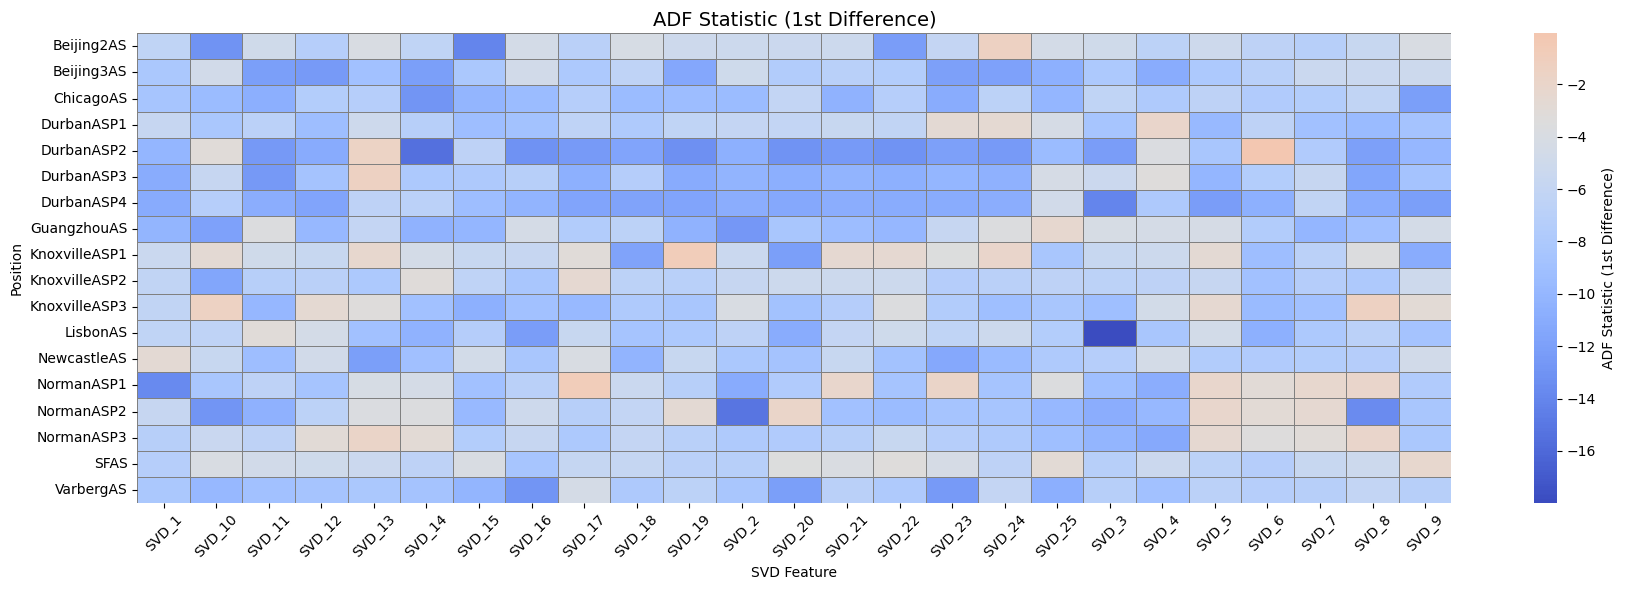

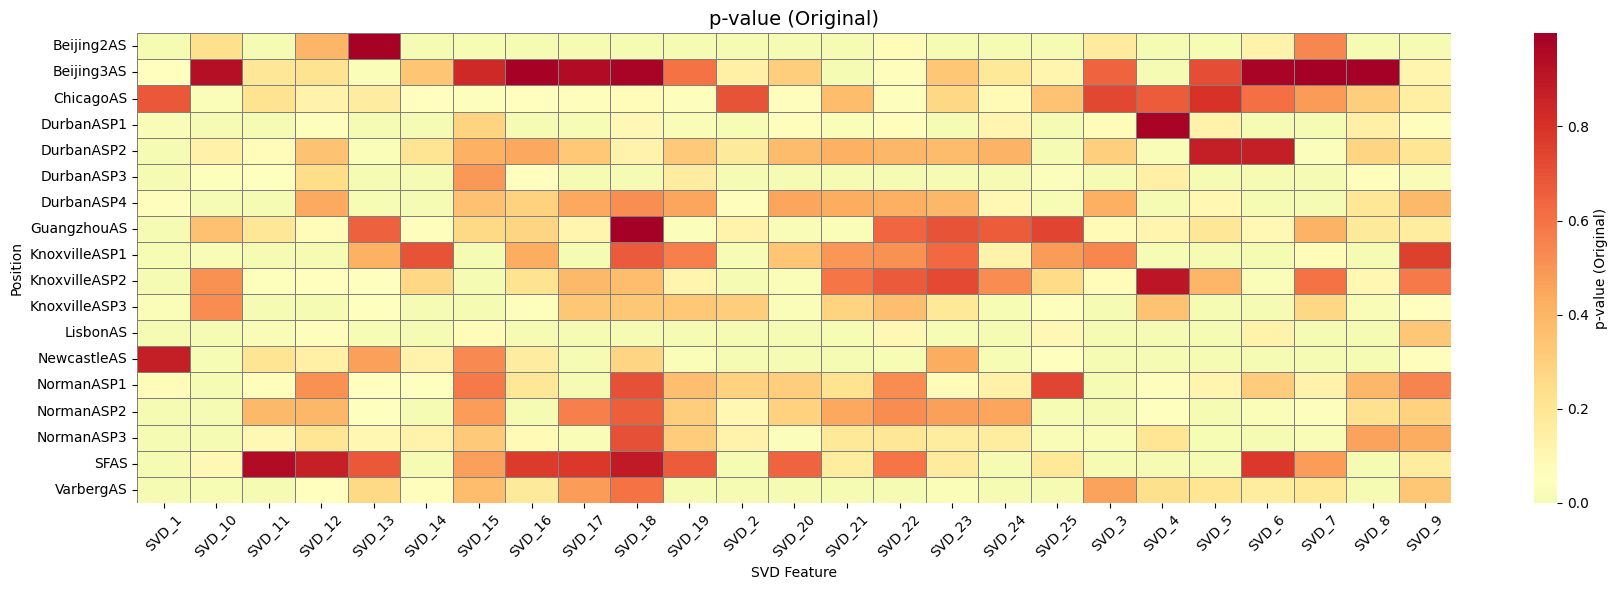

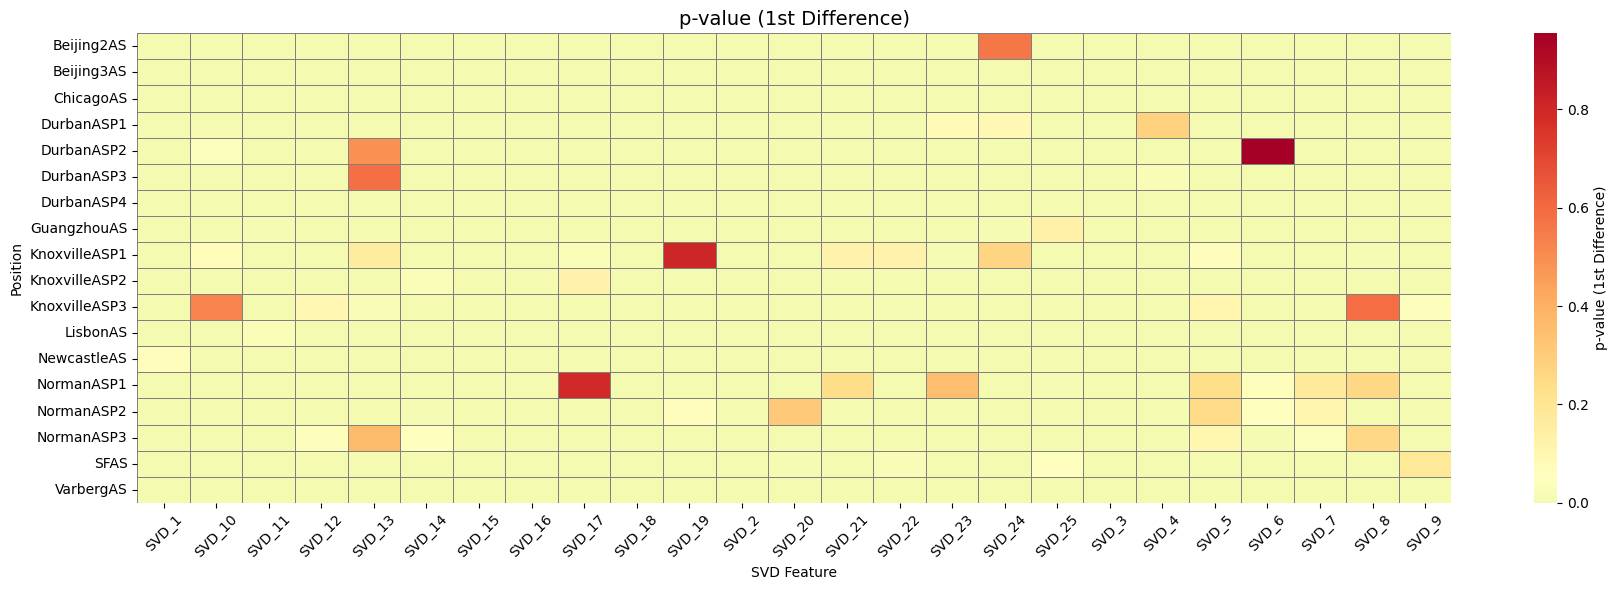

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns


# ‚úÖ ÌîºÎ≤ó ÌÖåÏù¥Î∏îÎ°ú Î≥ÄÌôò (ÏãúÍ∞ÅÌôîÏö©)
pivot_adf_orig = adf_all_df.pivot(index="Position", columns="SVD_Feature", values="ADF_Original")
pivot_adf_diff = adf_all_df.pivot(index="Position", columns="SVD_Feature", values="ADF_Diff")

pivot_p_orig = adf_all_df.pivot(index="Position", columns="SVD_Feature", values="p_Original")
pivot_p_diff = adf_all_df.pivot(index="Position", columns="SVD_Feature", values="p_Diff")

# üî∑ Heatmap ÏãúÍ∞ÅÌôî Ìï®Ïàò Ï†ïÏùò
def plot_heatmap(data, title, center=None, cmap="coolwarm"):
    plt.figure(figsize=(18, 6))
    sns.heatmap(data, annot=False, fmt=".2f", cmap=cmap, center=center,
                cbar_kws={"label": title}, linewidths=0.5, linecolor='gray')
    plt.title(title, fontsize=14)
    plt.xlabel("SVD Feature")
    plt.ylabel("Position")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# üî∑ ÏãúÍ∞ÅÌôî Ïã§Ìñâ
plot_heatmap(pivot_adf_orig, "ADF Statistic (Original)", center=-3.44)
plot_heatmap(pivot_adf_diff, "ADF Statistic (1st Difference)", center=-3.44)

plot_heatmap(pivot_p_orig, "p-value (Original)", center=0.05, cmap="RdYlGn_r")
plot_heatmap(pivot_p_diff, "p-value (1st Difference)", center=0.05, cmap="RdYlGn_r")


In [30]:
log_series = np.log(svd_series + 1)  # 0 Î∞©ÏßÄ
adfuller(log_series.dropna())


/Users/k23070952/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(-4.136595124657467,
 0.0008420786744868315,
 0,
 29,
 {'1%': -3.6790595944893187,
  '5%': -2.9678817237279103,
  '10%': -2.6231583472057074},
 66.07052340452529)

In [35]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# 1. ÎÇ†Ïßú ÌòïÏãù Ï†ïÎ¶¨
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

# 2. ÎåÄÏÉÅ Ïª¨Îüº ÏßÄÏ†ï
svd_cols = [col for col in merged_df.columns if col.startswith("SVD_")]
positions = merged_df["Position"].unique()

# 3. Í≤∞Í≥º Ï†ÄÏû• Î¶¨Ïä§Ìä∏
results = []

# 4. Í∞Å Í≥µÏ†ïÎ≥Ñ ADF ÌÖåÏä§Ìä∏ ÏàòÌñâ
for plant in positions:
    plant_df = merged_df[merged_df['Position'] == plant].sort_values("Date")
    plant_df = plant_df.set_index("Date")
    
    for svd_col in svd_cols:
        if svd_col not in plant_df.columns:
            continue
        
        svd_series = plant_df[svd_col].dropna()
        if len(svd_series) < 10:
            continue

        try:
            # üîπ ADF - ÏõêÎ≥∏
            result_orig = adfuller(svd_series)
            adf_stat_orig, pval_orig = result_orig[0], result_orig[1]

            # üîπ ADF - 1Ï∞® Ï∞®Î∂Ñ
            diff_series = svd_series.diff().dropna()
            result_diff = adfuller(diff_series)
            adf_stat_diff, pval_diff = result_diff[0], result_diff[1]

            # üîπ ADF - Î°úÍ∑∏Î≥ÄÌôò + 1Ï∞® Ï∞®Î∂Ñ (ÏùåÏàò Î≥¥Ìò∏Î•º ÏúÑÌï¥ shift)
            min_val = svd_series.min()
            if min_val <= 0:
                shift_val = abs(min_val) + 1e-6
                shifted_series = svd_series + shift_val
            else:
                shifted_series = svd_series

            try:
                log_series = np.log(shifted_series)
                log_diff_series = log_series.diff().dropna()
                result_logdiff = adfuller(log_diff_series)
                log_diff_stat, log_diff_pval = result_logdiff[0], result_logdiff[1]
            except:
                log_diff_stat, log_diff_pval = np.nan, np.nan

            # üîπ Í≤∞Í≥º Ï†ÄÏû•
            results.append({
                "Position": plant,
                "SVD_Feature": svd_col,
                "ADF_Original": adf_stat_orig,
                "p_Original": pval_orig,
                "ADF_Diff": adf_stat_diff,
                "p_Diff": pval_diff,
                "ADF_LogDiff": log_diff_stat,
                "p_LogDiff": log_diff_pval
            })

        except Exception as e:
            continue

# 5. DataFrameÏúºÎ°ú Ï†ÄÏû•
adf_all_df = pd.DataFrame(results)




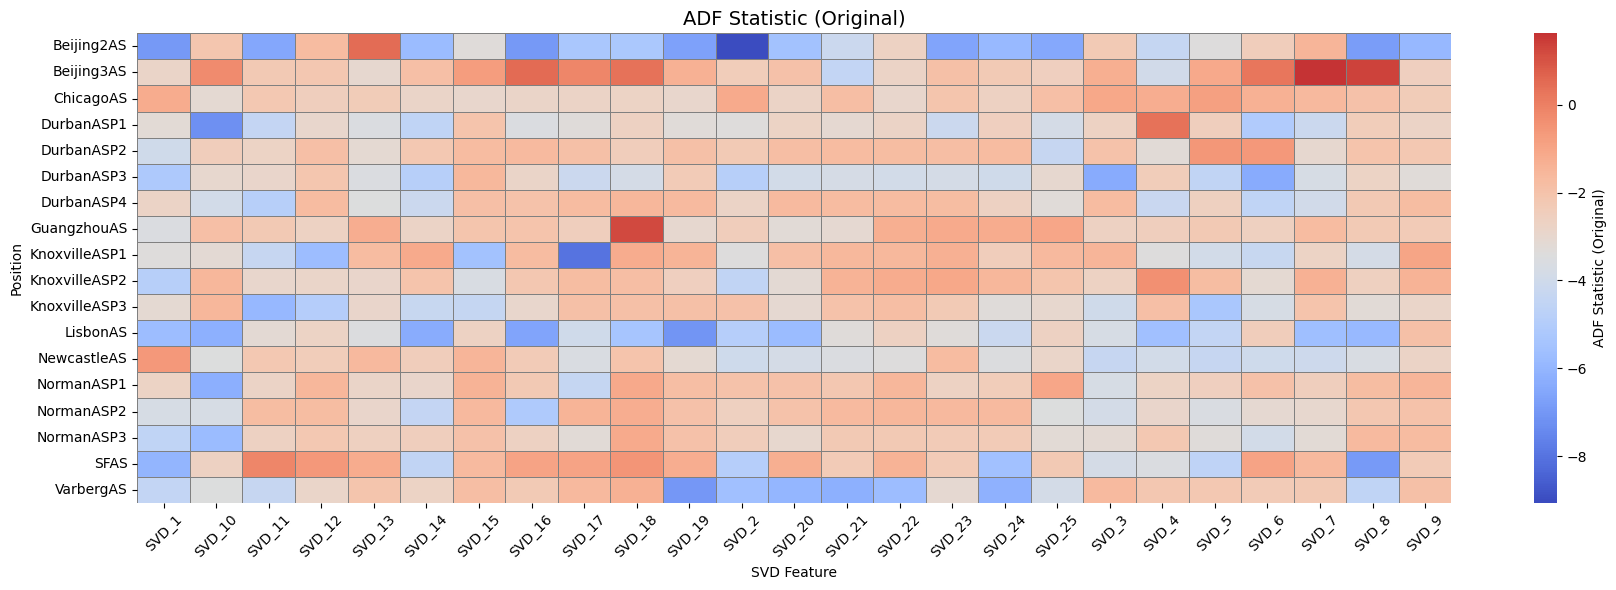

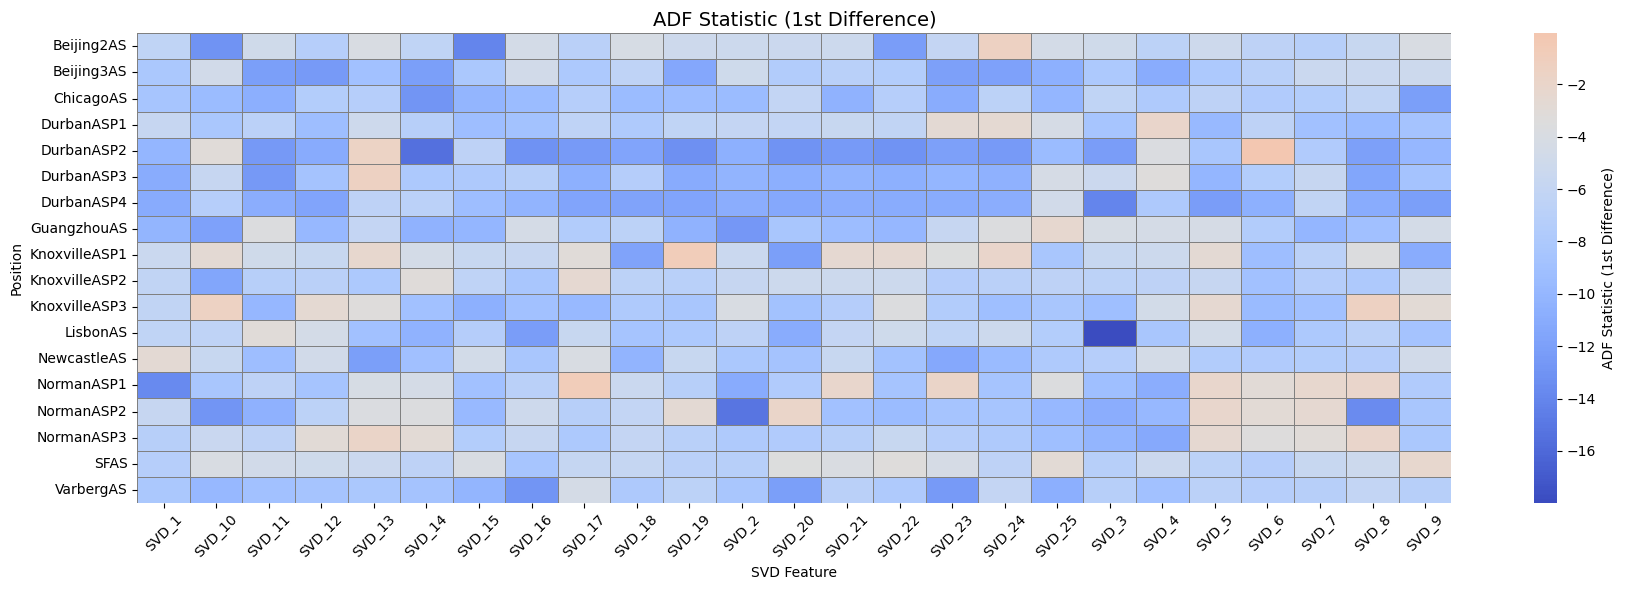

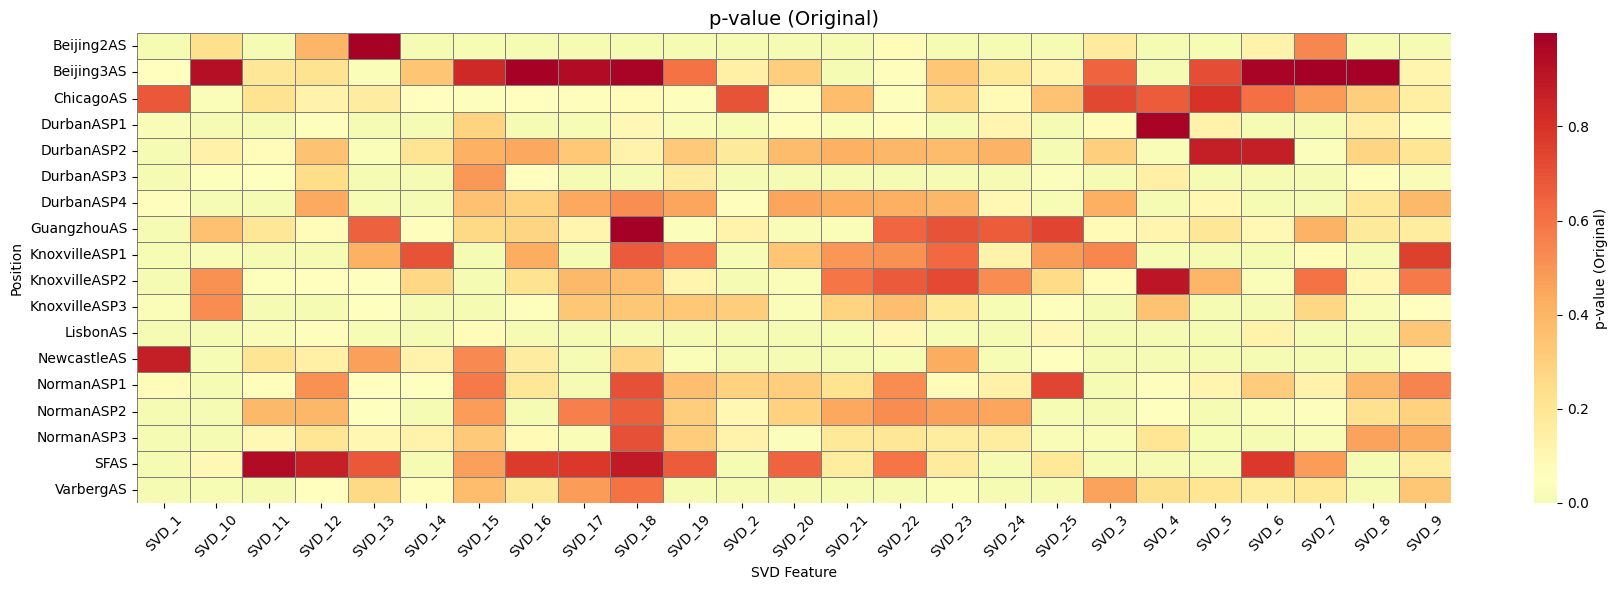

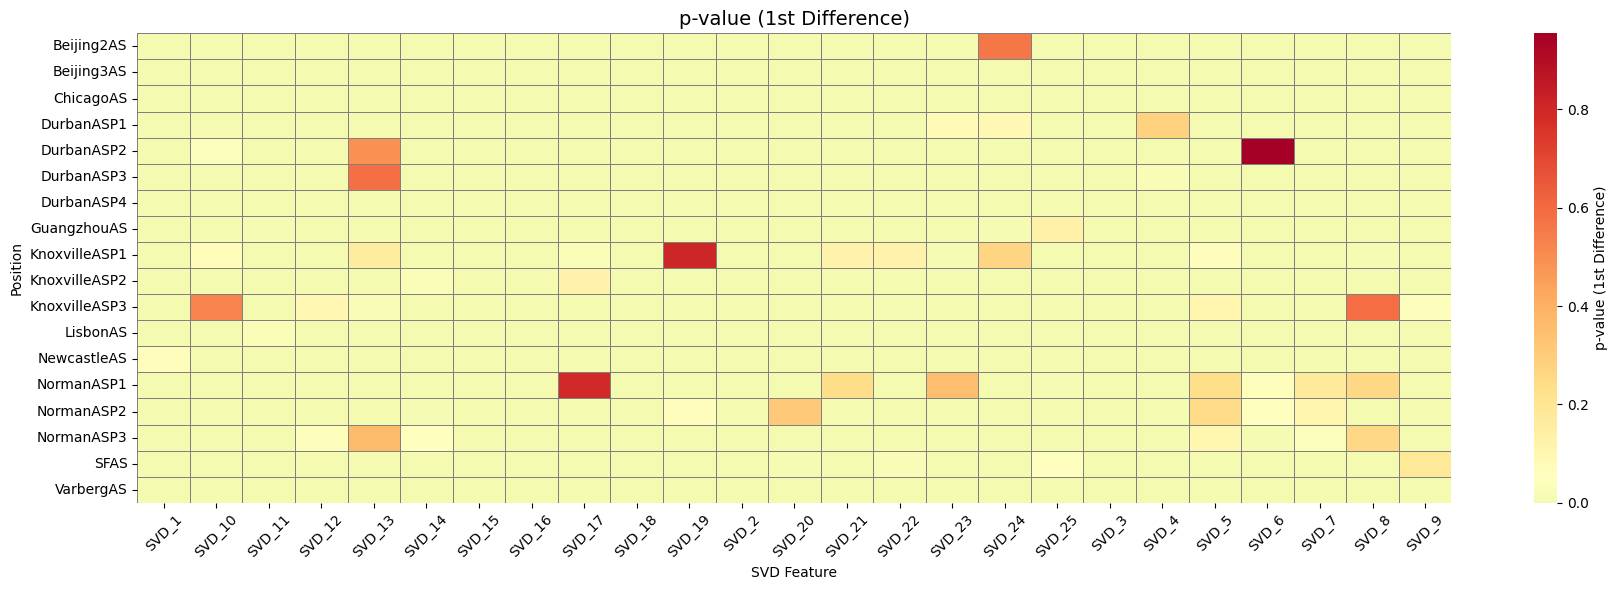

In [36]:
# ‚úÖ ÌîºÎ≤ó ÌÖåÏù¥Î∏îÎ°ú Î≥ÄÌôò (ÏãúÍ∞ÅÌôîÏö©)
pivot_adf_orig = adf_all_df.pivot(index="Position", columns="SVD_Feature", values="ADF_Original")
pivot_adf_diff = adf_all_df.pivot(index="Position", columns="SVD_Feature", values="ADF_Diff")

pivot_p_orig = adf_all_df.pivot(index="Position", columns="SVD_Feature", values="p_Original")
pivot_p_diff = adf_all_df.pivot(index="Position", columns="SVD_Feature", values="p_Diff")

# üî∑ Heatmap ÏãúÍ∞ÅÌôî Ìï®Ïàò Ï†ïÏùò
def plot_heatmap(data, title, center=None, cmap="coolwarm"):
    plt.figure(figsize=(18, 6))
    sns.heatmap(data, annot=False, fmt=".2f", cmap=cmap, center=center,
                cbar_kws={"label": title}, linewidths=0.5, linecolor='gray')
    plt.title(title, fontsize=14)
    plt.xlabel("SVD Feature")
    plt.ylabel("Position")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# üî∑ ÏãúÍ∞ÅÌôî Ïã§Ìñâ
plot_heatmap(pivot_adf_orig, "ADF Statistic (Original)", center=-3.44)
plot_heatmap(pivot_adf_diff, "ADF Statistic (1st Difference)", center=-3.44)

plot_heatmap(pivot_p_orig, "p-value (Original)", center=0.05, cmap="RdYlGn_r")
plot_heatmap(pivot_p_diff, "p-value (1st Difference)", center=0.05, cmap="RdYlGn_r")